In [1]:
#Save con Nodos
import os
from keras.models import load_model
import itertools
from matplotlib import pyplot as plt
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import os, sys
dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from sklearn.utils import class_weight
import numpy as np

from evaluation import calculate_metrics
from sklearn.metrics import confusion_matrix,accuracy_score
import pandas as pd
from keras.regularizers import l2
from keras.activations import tanh
from keras.models import Sequential
from keras.layers import *
from keras.losses import categorical_crossentropy,binary_crossentropy
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from keras import backend as K
from time import time
import random
from random import shuffle,seed
from sklearn.metrics import classification_report
import math
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.backend import eval



Using TensorFlow backend.


In [2]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix
from sklearn.preprocessing import normalize
import time

def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [3]:
fold = "../../KOI_Data/"
df_sets = pd.read_csv(fold+"/koi_sets.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values
df_sets.head()

,KOI Name,Set
0,K00889.01,Train
1,K01009.01,Train
2,K07621.01,Test
3,K06252.01,Test
4,K00958.01,Unlabeled


In [4]:
df_meta = pd.read_csv(fold+"/koi_metadata.csv")
df_meta_train = df_meta[mask_train]
df_meta_test = df_meta[mask_test]
df_meta_unb = df_meta[mask_unlabeled]

df_meta_train.head()

,KOI Name,NExScI Disposition,Kepler Name,Period,Time of Transit Epoch,First Transit Time (BJD),Impact Parameter,Duration,Transit Depth,r/R,...,Teff,log(g),Metallicity,Stellar Radius,Stellar Mass,Max single event sigma,Max Multievent sigma,Transit Model SNR,KOI count,Transit Number
0,K00889.01,CONFIRMED,Kepler-75 b,8.884923,169.991686,2455002.992,0.069,2.07004,16053.4,0.114,...,5332.0,4.500,-0.08,0.843,0.821,61.291,474.021,388.2,1,153
1,K01009.01,FALSE POSITIVE,NaN,5.092465,357.535940,2455190.536,0.161,3.65900,254.0,0.014,...,5037.0,4.547,-0.20,0.751,0.727,3.648,15.175,17.1,1,225
7,K07622.01,FALSE POSITIVE,NaN,36.267167,155.081300,2454988.081,0.214,2.06500,627.1,0.022,...,4264.0,4.637,-0.20,0.620,0.607,3.016,7.472,10.0,1,39
9,K00998.01,FALSE POSITIVE,NaN,161.788327,214.039000,2455047.039,0.267,5.31000,87750.0,0.273,...,6018.0,4.327,0.18,1.212,1.142,341.666,806.993,704.5,1,9
10,K00992.01,CONFIRMED,Kepler-745 b,9.931463,136.491280,2454969.491,0.037,5.67800,398.6,0.018,...,5782.0,4.280,0.16,1.220,1.035,4.530,22.901,26.2,2,137


In [5]:
y_train= (df_meta_train['NExScI Disposition'].values=="CONFIRMED")*1
y_val = (df_meta_test['NExScI Disposition'].values=="CONFIRMED")*1

### data augm

In [6]:
x_all = np.load("/work/work_teamEXOPLANET/MTF_margarita/no_invertidos/MTF_u15_d30.npy")
x_all2 = np.load("/work/work_teamEXOPLANET/MTF_margarita/invertidos/MTF_u15_d30.npy")

x_train1 = x_all[mask_train]
x_val = x_all[mask_test]
#x_unb = x_all[mask_unlabeled]

x_train2 = x_all2[mask_train]


x_train = np.concatenate([x_train1,x_train2])
if x_train.shape[0] != y_train.shape[0]:
    y_train = np.tile(y_train, (2))

x_train=np.expand_dims(np.asarray(x_train), axis=-1)
x_val=np.expand_dims(np.asarray(x_val), axis=-1)
#x_test=np.expand_dims(np.asarray(x_test), axis=-1)

print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

Objetos de entrenamiento: (8678, 45, 45, 1) (8678,)
Objetos de validación: (1918, 45, 45, 1) (1918,)


## canales

In [6]:
!ls /work/work_teamEXOPLANET/MTF_margarita/no_invertidos

MTF_u10_d10.npy  MTF_u10_d30.npy  MTF_u15_d20.npy  MTF_u5_d15.npy
MTF_u10_d15.npy  MTF_u15_d10.npy  MTF_u15_d30.npy  MTF_u5_d20.npy
MTF_u10_d20.npy  MTF_u15_d15.npy  MTF_u5_d10.npy   MTF_u5_d30.npy


In [6]:
x_all1 = np.load("/work/work_teamEXOPLANET/MTF_margarita/no_invertidos/MTF_u15_d15.npy")
x_all2 = np.load("/work/work_teamEXOPLANET/MTF_margarita/invertidos/MTF_u15_d15.npy")

x_all = np.concatenate([x_all1[:,:,:,None],x_all2[:,:,:,None]], axis=-1)

x_train = x_all[mask_train]
x_val = x_all[mask_test]
#x_unb = x_all[mask_unlabeled]

if x_train.shape[0] < y_train.shape[0]:
    y_train = y_train[:x_train.shape[0]]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

Objetos de entrenamiento: (4339, 30, 30, 2) (4339,)
Objetos de validación: (1918, 30, 30, 2) (1918,)


In [40]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)#{0: 3.,   1: 6.,   2: 5.,  3: 3.}
print (class_weights)

[0.86762575 1.18003941]


In [10]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [64]:
model = Sequential()
model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(256, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 1800)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               461056    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 462,337
Trainable params: 461,825
Non-trainable params: 512
_________________________________________________________________


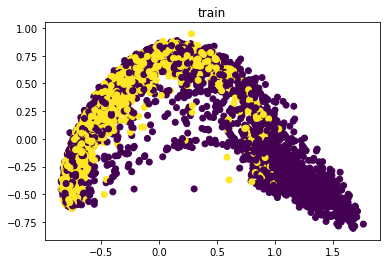

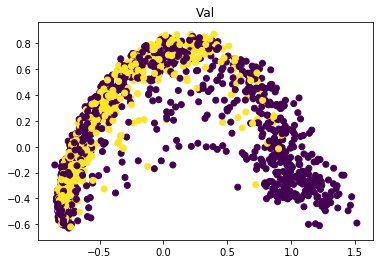

In [15]:
from sklearn.decomposition import PCA
dims_r = np.prod(x_train.shape[1:])

model = PCA(2)
plot_x = model.fit_transform(x_train.reshape([x_train.shape[0],dims_r]))
plt.scatter(plot_x[:,0],plot_x[:,1], c=y_train, cmap='viridis') #morado es falso positivo
plt.title("train")
plt.show()

plot_x = model.transform(x_val.reshape([x_val.shape[0],dims_r]))
plt.scatter(plot_x[:,0],plot_x[:,1], c=y_val, cmap='viridis') #morado es falso positivo
plt.title("Val")
plt.show()

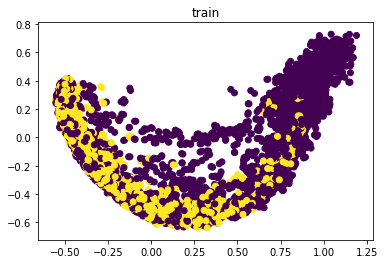

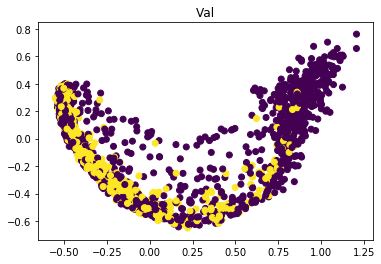

In [16]:
#nuevo test...

from sklearn.decomposition import PCA
dims_r = np.prod(x_train.shape[1:])
model = PCA(2)
plot_x = model.fit_transform(x_train.reshape([x_train.shape[0],dims_r]))
plt.scatter(plot_x[:,0],plot_x[:,1], c=y_train, cmap='viridis') #morado es falso positivo
plt.title("train")
plt.show()

plot_x = model.transform(x_val.reshape([x_val.shape[0],dims_r]))
plt.scatter(plot_x[:,0],plot_x[:,1], c=y_val, cmap='viridis') #morado es falso positivo
plt.title("Val")

plt.show()

In [65]:
import keras
class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []

    def on_epoch_end(self, batch, logs={}):
        predict = np.squeeze(self.model.predict_classes(self.validation_data[0]))
        targ = np.squeeze(self.validation_data[1])
        f1s = f1_score(targ, predict, average='macro')
        self.val_f1s.append(f1s)
        print(" - val_f1: %f " %(f1s))
        return
metrics = Metrics()

Train on 4339 samples, validate on 1918 samples
Epoch 1/200
4339/4339 [==============================] - 2s 423us/step - loss: 0.8521 - acc: 0.5978 - val_loss: 0.6799 - val_acc: 0.6251
 - val_f1: 0.625056 
Epoch 2/200
4339/4339 [==============================] - 0s 88us/step - loss: 0.6007 - acc: 0.6568 - val_loss: 0.5914 - val_acc: 0.6350
 - val_f1: 0.634861 
Epoch 3/200
4339/4339 [==============================] - 0s 86us/step - loss: 0.5837 - acc: 0.6582 - val_loss: 0.5369 - val_acc: 0.6741
 - val_f1: 0.620515 
Epoch 4/200
4339/4339 [==============================] - 0s 91us/step - loss: 0.5405 - acc: 0.6926 - val_loss: 0.5641 - val_acc: 0.6653
 - val_f1: 0.659397 
Epoch 5/200
4339/4339 [==============================] - 0s 85us/step - loss: 0.5360 - acc: 0.6990 - val_loss: 0.5380 - val_acc: 0.6950
 - val_f1: 0.660547 
Epoch 6/200
4339/4339 [==============================] - 0s 91us/step - loss: 0.5109 - acc: 0.7128 - val_loss: 0.5383 - val_acc: 0.6835
 - val_f1: 0.668602 
Epoch 7/2

 - val_f1: 0.674339 
Epoch 53/200
4339/4339 [==============================] - 0s 86us/step - loss: 0.4078 - acc: 0.7944 - val_loss: 0.5662 - val_acc: 0.7044
 - val_f1: 0.665081 
Epoch 54/200
4339/4339 [==============================] - 0s 86us/step - loss: 0.4144 - acc: 0.7914 - val_loss: 0.5572 - val_acc: 0.7013
 - val_f1: 0.671750 
Epoch 55/200
4339/4339 [==============================] - 0s 88us/step - loss: 0.4122 - acc: 0.7861 - val_loss: 0.5688 - val_acc: 0.7013
 - val_f1: 0.681906 
Epoch 56/200
4339/4339 [==============================] - 0s 84us/step - loss: 0.4135 - acc: 0.7926 - val_loss: 0.6285 - val_acc: 0.6903
 - val_f1: 0.669054 
Epoch 57/200
4339/4339 [==============================] - 0s 87us/step - loss: 0.4044 - acc: 0.8004 - val_loss: 0.5707 - val_acc: 0.7117
 - val_f1: 0.650030 
Epoch 58/200
4339/4339 [==============================] - 0s 89us/step - loss: 0.4139 - acc: 0.7903 - val_loss: 0.6234 - val_acc: 0.7018
 - val_f1: 0.596407 
Epoch 59/200
4339/4339 [=======

 - val_f1: 0.642412 
Epoch 105/200
4339/4339 [==============================] - 0s 91us/step - loss: 0.3967 - acc: 0.8041 - val_loss: 0.5909 - val_acc: 0.7091
 - val_f1: 0.681320 
Epoch 106/200
4339/4339 [==============================] - 0s 86us/step - loss: 0.3878 - acc: 0.8078 - val_loss: 0.5689 - val_acc: 0.7091
 - val_f1: 0.668085 
Epoch 107/200
4339/4339 [==============================] - 0s 89us/step - loss: 0.3903 - acc: 0.8023 - val_loss: 0.5772 - val_acc: 0.7112
 - val_f1: 0.672628 
Epoch 108/200
4339/4339 [==============================] - 0s 85us/step - loss: 0.3883 - acc: 0.8106 - val_loss: 0.5706 - val_acc: 0.7091
 - val_f1: 0.673636 
Epoch 109/200
4339/4339 [==============================] - 0s 84us/step - loss: 0.3949 - acc: 0.8023 - val_loss: 0.5681 - val_acc: 0.7091
 - val_f1: 0.672364 
Epoch 110/200
4339/4339 [==============================] - 0s 88us/step - loss: 0.3883 - acc: 0.8106 - val_loss: 0.5694 - val_acc: 0.7127
 - val_f1: 0.679801 
Epoch 111/200
4339/4339 [

4339/4339 [==============================] - 0s 87us/step - loss: 0.3693 - acc: 0.8276 - val_loss: 0.5769 - val_acc: 0.7106
 - val_f1: 0.677476 
Epoch 157/200
4339/4339 [==============================] - 0s 87us/step - loss: 0.3700 - acc: 0.8205 - val_loss: 0.6467 - val_acc: 0.6940
 - val_f1: 0.686842 
Epoch 158/200
4339/4339 [==============================] - 0s 89us/step - loss: 0.3803 - acc: 0.8110 - val_loss: 0.5765 - val_acc: 0.7237
 - val_f1: 0.693473 
Epoch 159/200
4339/4339 [==============================] - 0s 86us/step - loss: 0.3645 - acc: 0.8248 - val_loss: 0.5797 - val_acc: 0.7158
 - val_f1: 0.681851 
Epoch 160/200
4339/4339 [==============================] - 0s 91us/step - loss: 0.3730 - acc: 0.8170 - val_loss: 0.5985 - val_acc: 0.7231
 - val_f1: 0.665017 
Epoch 161/200
4339/4339 [==============================] - 0s 86us/step - loss: 0.3702 - acc: 0.8214 - val_loss: 0.6004 - val_acc: 0.7190
 - val_f1: 0.654418 
Epoch 162/200
4339/4339 [==============================] - 0

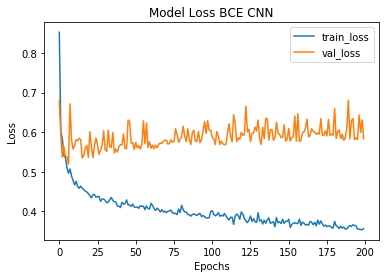

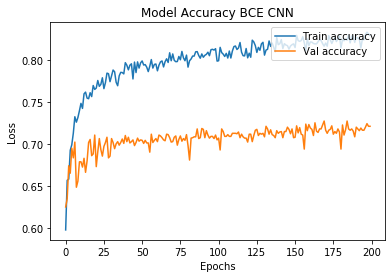

KeyError: 'val_f1'

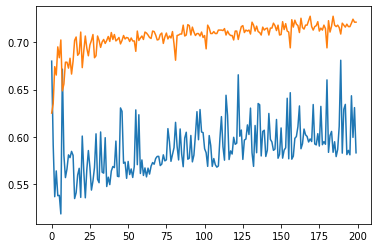

In [66]:
hist=model.fit(x_train, y_train, batch_size=128, epochs=200, verbose=1, validation_data=(x_val,y_val),
              callbacks=[metrics])
plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist.history['acc'],label="Train accuracy" )
plt.plot(hist.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist.history['val_loss'],label="loss" )
plt.plot(hist.history['val_acc'],label="accuracy" )
plt.plot(hist.history['val_f1'],label="F1" )
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()


,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.859813,0.663994,0.749321,0.717823,0.704304,0.711157
Confirmed,0.561257,0.798808,0.659287,0.717823,0.704304,0.711157


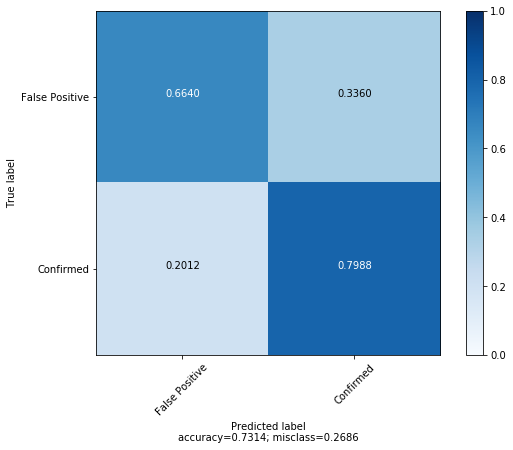

{'Precision raw': array([0.85981308, 0.56125654]), 'Recall raw': array([0.66399358, 0.79880775]), 'F1 raw': array([0.74932127, 0.65928659]), 'F1 weighted': 0.7178232136196769, 'F1 macro': 0.7043039299171272, 'F1 micro': 0.7111574556830031, 'Confusion Matrix': array([[828, 419],
       [135, 536]])}


In [63]:
predichos=model.predict_classes(x_val)
print (calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC'))

In [7]:
def train_model(aux_model, x_train, y_train, x_val, y_val, e=25, BS=128):
    hist=aux_model.fit(x_train, y_train, batch_size=BS, epochs=e, verbose=1, validation_data=(x_val,y_val))
    plt.plot(hist.history['loss'],label="train_loss")
    plt.plot(hist.history['val_loss'],label="val_loss")
    plt.title("Model Loss BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    plt.plot(hist.history['acc'],label="Train accuracy" )
    plt.plot(hist.history['val_acc'],label="Val accuracy" )
    plt.title("Model Accuracy BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    predichos=aux_model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')

### Modelo 1

In [8]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), strides=(1, 1),activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
#model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 43, 43, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     


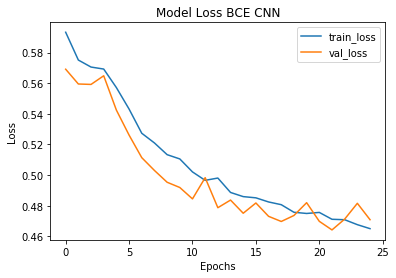

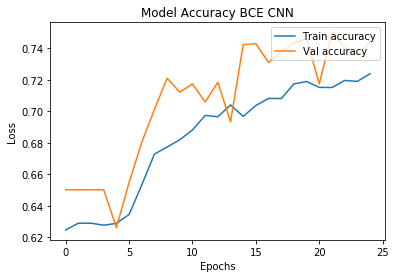

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.785498,0.834002,0.809024,0.740046,0.710441,0.744004
Confirmed,0.651515,0.576751,0.611858,0.740046,0.710441,0.744004


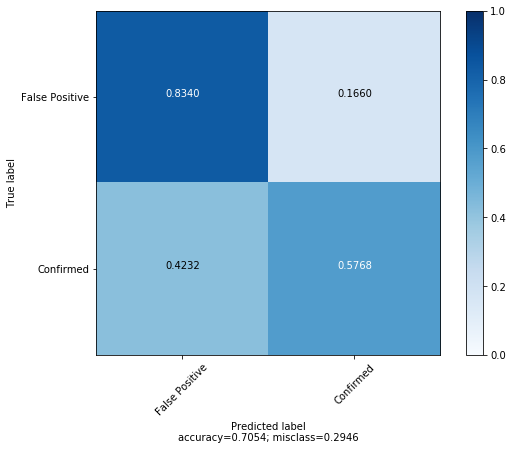

In [33]:
train_model(model, x_train, y_train, x_val, y_val, e=25)

Train on 8678 samples, validate on 1918 samples
Epoch 1/40
8678/8678 [==============================] - 9s 1ms/step - loss: 0.5983 - acc: 0.6270 - val_loss: 0.5561 - val_acc: 0.6502
Epoch 2/40
8678/8678 [==============================] - 7s 829us/step - loss: 0.5701 - acc: 0.6289 - val_loss: 0.5630 - val_acc: 0.6502
Epoch 3/40
8678/8678 [==============================] - 8s 915us/step - loss: 0.5683 - acc: 0.6291 - val_loss: 0.5567 - val_acc: 0.6502
Epoch 4/40
8678/8678 [==============================] - 8s 886us/step - loss: 0.5585 - acc: 0.6289 - val_loss: 0.5419 - val_acc: 0.6481
Epoch 5/40
8678/8678 [==============================] - 8s 939us/step - loss: 0.5405 - acc: 0.6424 - val_loss: 0.5294 - val_acc: 0.6408
Epoch 6/40
8678/8678 [==============================] - 8s 893us/step - loss: 0.5276 - acc: 0.6599 - val_loss: 0.5136 - val_acc: 0.6747
Epoch 7/40
8678/8678 [==============================] - 8s 893us/step - loss: 0.5240 - acc: 0.6689 - val_loss: 0.5132 - val_acc: 0.6741
Ep

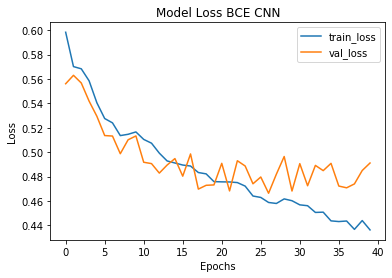

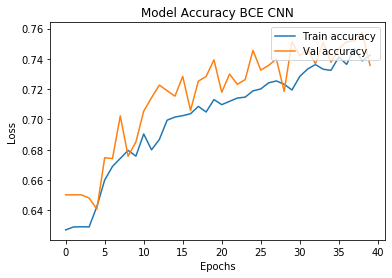

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.787714,0.812350,0.799842,0.733741,0.70537,0.735662
Confirmed,0.629747,0.593145,0.610898,0.733741,0.70537,0.735662


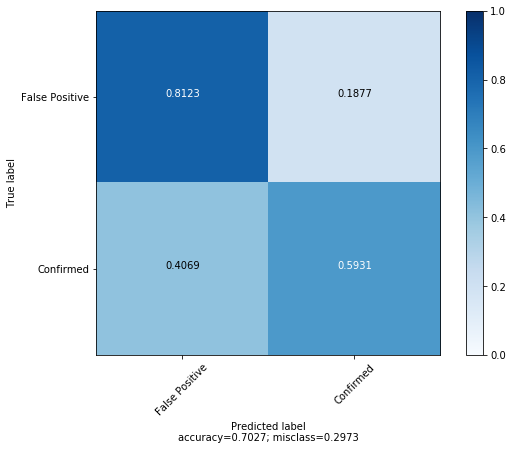

In [9]:
train_model(model, x_train, y_train, x_val, y_val, e=40)

### Modelo 1 sobre viejo validation..

In [51]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), strides=(1, 1),activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
#model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 43, 43, 32)        320       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 20, 20, 32)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 18, 18, 64)        18496     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 8, 8, 64)         

Train on 9384 samples, validate on 1565 samples
Epoch 1/25
9384/9384 [==============================] - 12s 1ms/step - loss: 0.5949 - acc: 0.6208 - val_loss: 0.6344 - val_acc: 0.6773
Epoch 2/25
9384/9384 [==============================] - 10s 1ms/step - loss: 0.5621 - acc: 0.6293 - val_loss: 0.5955 - val_acc: 0.5712
Epoch 3/25
9384/9384 [==============================] - 11s 1ms/step - loss: 0.5539 - acc: 0.6395 - val_loss: 0.5980 - val_acc: 0.5553
Epoch 4/25
9384/9384 [==============================] - 11s 1ms/step - loss: 0.5376 - acc: 0.6573 - val_loss: 0.5917 - val_acc: 0.5406
Epoch 5/25
9384/9384 [==============================] - 10s 1ms/step - loss: 0.5225 - acc: 0.6616 - val_loss: 0.5620 - val_acc: 0.6665
Epoch 6/25
9384/9384 [==============================] - 11s 1ms/step - loss: 0.5018 - acc: 0.6848 - val_loss: 0.5730 - val_acc: 0.6837
Epoch 7/25
9384/9384 [==============================] - 11s 1ms/step - loss: 0.4969 - acc: 0.6894 - val_loss: 0.5612 - val_acc: 0.6907
Epoch 8

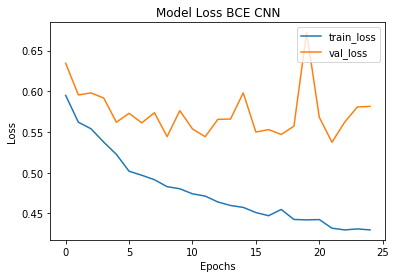

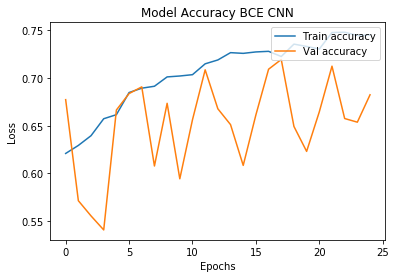

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.790506,0.722642,0.755052,0.688431,0.651822,0.682428
Confirmed,0.506711,0.598020,0.548592,0.688431,0.651822,0.682428


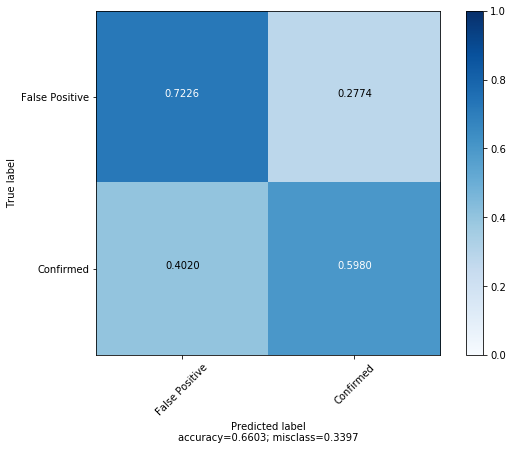

In [52]:
train_model(model, x_train, y_train, x_val, y_val, e=25)

### Modelo 2

In [10]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(Conv2D(32, (3, 3), strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (2, 2), strides=(1, 1), activation="relu", padding="valid"))
model.add(Flatten())
#model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 43, 43, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 18, 18, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)         

Train on 9384 samples, validate on 1565 samples
Epoch 1/25
9384/9384 [==============================] - 11s 1ms/step - loss: 0.5831 - acc: 0.6225 - val_loss: 0.6085 - val_acc: 0.5476
Epoch 2/25
9384/9384 [==============================] - 9s 914us/step - loss: 0.5499 - acc: 0.6498 - val_loss: 0.6199 - val_acc: 0.5176
Epoch 3/25
9384/9384 [==============================] - 9s 1ms/step - loss: 0.5228 - acc: 0.6639 - val_loss: 0.5645 - val_acc: 0.6863
Epoch 4/25
9384/9384 [==============================] - 9s 937us/step - loss: 0.5067 - acc: 0.6740 - val_loss: 0.5929 - val_acc: 0.5796
Epoch 5/25
9384/9384 [==============================] - 9s 962us/step - loss: 0.5004 - acc: 0.6801 - val_loss: 0.5689 - val_acc: 0.7010
Epoch 6/25
9384/9384 [==============================] - 9s 955us/step - loss: 0.4928 - acc: 0.6831 - val_loss: 0.5691 - val_acc: 0.7029
Epoch 7/25
9384/9384 [==============================] - 9s 976us/step - loss: 0.4851 - acc: 0.6988 - val_loss: 0.5712 - val_acc: 0.6709
Epo

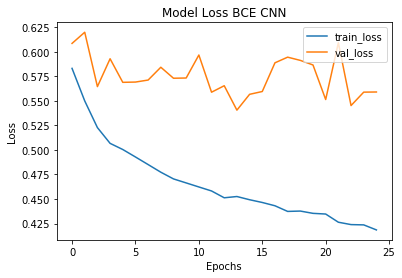

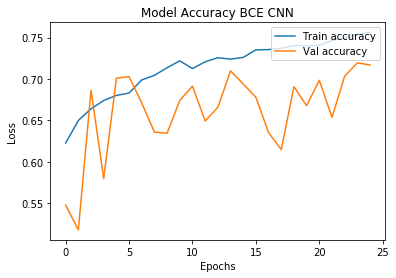

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.768494,0.833019,0.799457,0.708958,0.659229,0.716933
Confirmed,0.574519,0.473267,0.519001,0.708958,0.659229,0.716933


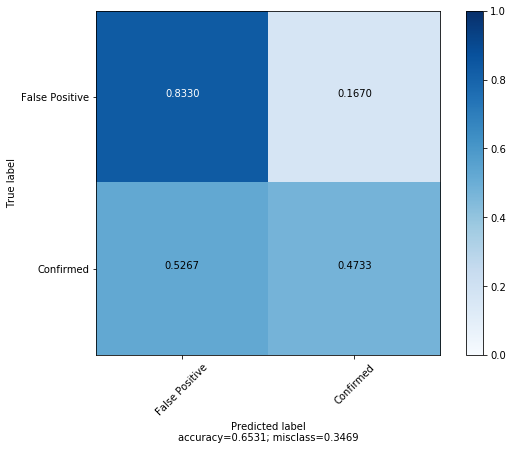

In [56]:
train_model(model, x_train, y_train, x_val, y_val, e=25)

Train on 8678 samples, validate on 1918 samples
Epoch 1/40
8678/8678 [==============================] - 14s 2ms/step - loss: 0.5933 - acc: 0.6281 - val_loss: 0.5557 - val_acc: 0.6502
Epoch 2/40
8678/8678 [==============================] - 12s 1ms/step - loss: 0.5682 - acc: 0.6292 - val_loss: 0.5599 - val_acc: 0.6502
Epoch 3/40
8678/8678 [==============================] - 11s 1ms/step - loss: 0.5636 - acc: 0.6268 - val_loss: 0.5498 - val_acc: 0.6502
Epoch 4/40
8678/8678 [==============================] - 11s 1ms/step - loss: 0.5423 - acc: 0.6445 - val_loss: 0.5286 - val_acc: 0.6663
Epoch 5/40
8678/8678 [==============================] - 11s 1ms/step - loss: 0.5306 - acc: 0.6546 - val_loss: 0.5178 - val_acc: 0.6924
Epoch 6/40
8678/8678 [==============================] - 11s 1ms/step - loss: 0.5234 - acc: 0.6711 - val_loss: 0.5092 - val_acc: 0.7117
Epoch 7/40
8678/8678 [==============================] - 11s 1ms/step - loss: 0.5210 - acc: 0.6777 - val_loss: 0.5060 - val_acc: 0.7091
Epoch 8

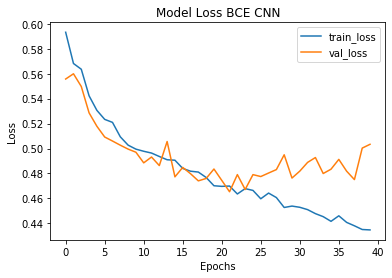

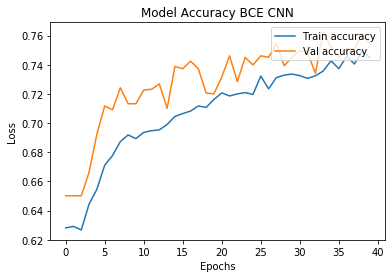

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.778577,0.868484,0.821077,0.745837,0.713543,0.75391
Confirmed,0.688805,0.540984,0.606010,0.745837,0.713543,0.75391


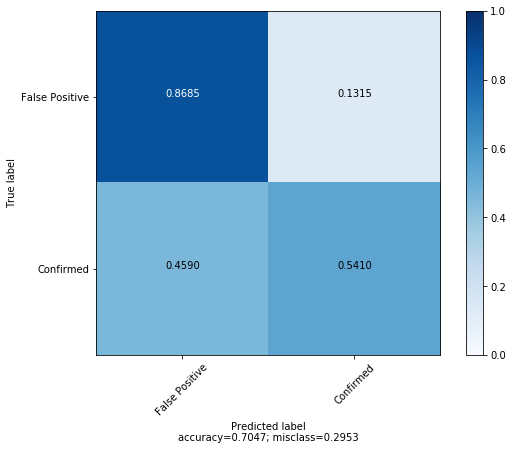

In [11]:
train_model(model, x_train, y_train, x_val, y_val, e=40) #old test

### Modelo 3

In [12]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(Conv2D(32, (3, 3), strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (2, 2), strides=(1, 1), activation="relu", padding="valid"))
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 43, 43, 32)        320       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 18, 18, 64)        18496     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)         

Train on 9384 samples, validate on 1565 samples
Epoch 1/25
9384/9384 [==============================] - 13s 1ms/step - loss: 0.5786 - acc: 0.6264 - val_loss: 0.5960 - val_acc: 0.5719
Epoch 2/25
9384/9384 [==============================] - 11s 1ms/step - loss: 0.5510 - acc: 0.6447 - val_loss: 0.5718 - val_acc: 0.5674
Epoch 3/25
9384/9384 [==============================] - 10s 1ms/step - loss: 0.5240 - acc: 0.6555 - val_loss: 0.5669 - val_acc: 0.5661
Epoch 4/25
9384/9384 [==============================] - 10s 1ms/step - loss: 0.5085 - acc: 0.6711 - val_loss: 0.5722 - val_acc: 0.5572
Epoch 5/25
9384/9384 [==============================] - 11s 1ms/step - loss: 0.5019 - acc: 0.6752 - val_loss: 0.5769 - val_acc: 0.5623
Epoch 6/25
9384/9384 [==============================] - 10s 1ms/step - loss: 0.4901 - acc: 0.6866 - val_loss: 0.5848 - val_acc: 0.6006
Epoch 7/25
9384/9384 [==============================] - 11s 1ms/step - loss: 0.4872 - acc: 0.6933 - val_loss: 0.5783 - val_acc: 0.6569
Epoch 8

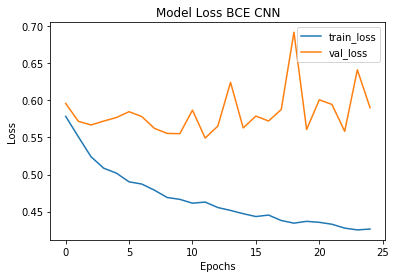

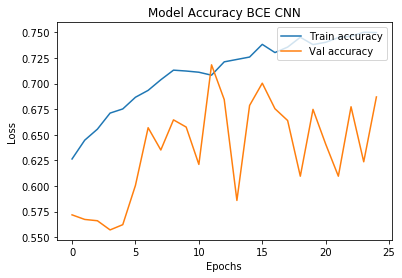

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.779961,0.749057,0.764196,0.689987,0.649208,0.686901
Confirmed,0.513711,0.556436,0.534221,0.689987,0.649208,0.686901


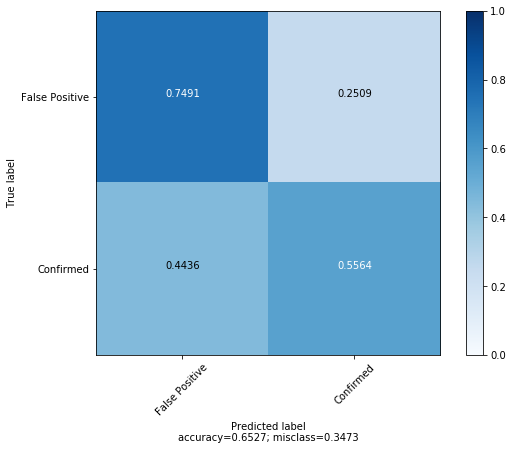

In [58]:
train_model(model, x_train, y_train, x_val, y_val, e=25)

Train on 8678 samples, validate on 1918 samples
Epoch 1/40
8678/8678 [==============================] - 12s 1ms/step - loss: 0.6096 - acc: 0.6279 - val_loss: 0.5595 - val_acc: 0.6502
Epoch 2/40
8678/8678 [==============================] - 12s 1ms/step - loss: 0.5713 - acc: 0.6289 - val_loss: 0.5523 - val_acc: 0.6502
Epoch 3/40
8678/8678 [==============================] - 12s 1ms/step - loss: 0.5606 - acc: 0.6316 - val_loss: 0.5421 - val_acc: 0.6335
Epoch 4/40
8678/8678 [==============================] - 12s 1ms/step - loss: 0.5422 - acc: 0.6432 - val_loss: 0.5110 - val_acc: 0.6992
Epoch 5/40
8678/8678 [==============================] - 12s 1ms/step - loss: 0.5258 - acc: 0.6602 - val_loss: 0.5097 - val_acc: 0.6804
Epoch 6/40
8678/8678 [==============================] - 12s 1ms/step - loss: 0.5287 - acc: 0.6616 - val_loss: 0.5105 - val_acc: 0.6736
Epoch 7/40
8678/8678 [==============================] - 12s 1ms/step - loss: 0.5169 - acc: 0.6755 - val_loss: 0.5020 - val_acc: 0.7075
Epoch 8

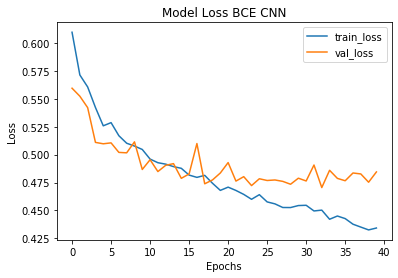

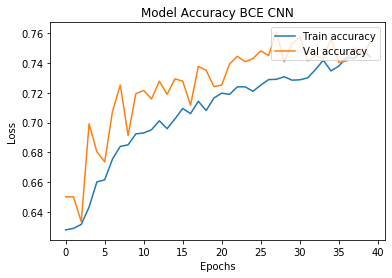

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.788806,0.847634,0.817163,0.74864,0.71923,0.753389
Confirmed,0.671280,0.578241,0.621297,0.74864,0.71923,0.753389


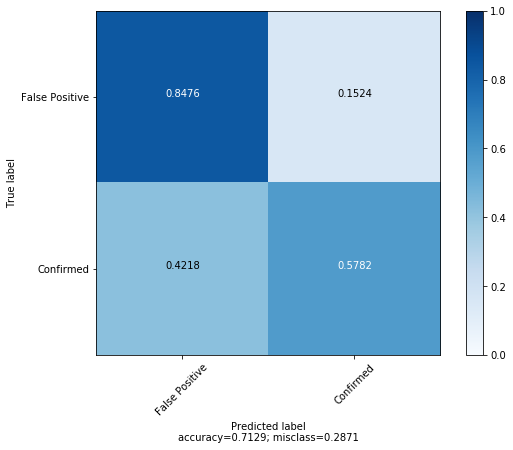

In [13]:
train_model(model, x_train, y_train, x_val, y_val, e=40) #old test

### Modelo 3 sin double

In [20]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (2, 2), strides=(1, 1), activation="relu", padding="valid"))
model.add(BatchNormalization())
#model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 43, 43, 32)        320       
_________________________________________________________________
batch_normalization_6 (Batch (None, 43, 43, 32)        128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 19, 19, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 19, 19, 64)        256       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 9, 9, 64)         

Train on 8678 samples, validate on 1918 samples
Epoch 1/40
8678/8678 [==============================] - 9s 1ms/step - loss: 0.5903 - acc: 0.6288 - val_loss: 0.5568 - val_acc: 0.6502
Epoch 2/40
8678/8678 [==============================] - 7s 838us/step - loss: 0.5671 - acc: 0.6289 - val_loss: 0.5639 - val_acc: 0.6502
Epoch 3/40
8678/8678 [==============================] - 8s 873us/step - loss: 0.5641 - acc: 0.6289 - val_loss: 0.5540 - val_acc: 0.6502
Epoch 4/40
8678/8678 [==============================] - 8s 886us/step - loss: 0.5602 - acc: 0.6300 - val_loss: 0.5474 - val_acc: 0.6502
Epoch 5/40
8678/8678 [==============================] - 7s 854us/step - loss: 0.5547 - acc: 0.6293 - val_loss: 0.5490 - val_acc: 0.6408
Epoch 6/40
8678/8678 [==============================] - 7s 809us/step - loss: 0.5470 - acc: 0.6179 - val_loss: 0.5381 - val_acc: 0.6502
Epoch 7/40
8678/8678 [==============================] - 7s 816us/step - loss: 0.5445 - acc: 0.6235 - val_loss: 0.5443 - val_acc: 0.6502
Ep

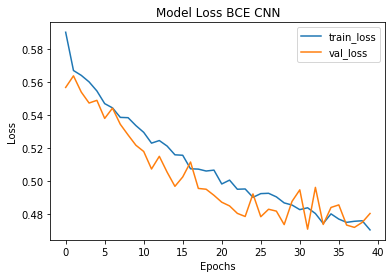

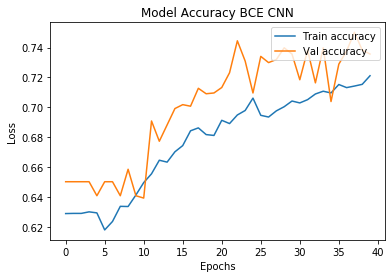

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.794586,0.800321,0.797443,0.735245,0.708549,0.735662
Confirmed,0.623867,0.615499,0.619655,0.735245,0.708549,0.735662


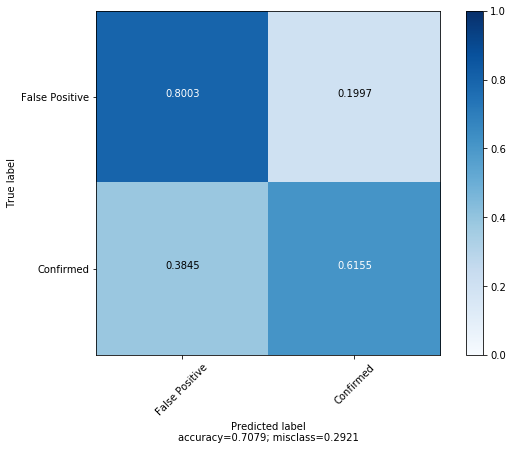

In [13]:
train_model(model, x_train, y_train, x_val, y_val, e=40) #con global pooling (con dropa)

Train on 8678 samples, validate on 1918 samples
Epoch 1/40
8678/8678 [==============================] - 39s 5ms/step - loss: 0.7357 - acc: 0.5945 - val_loss: 0.6016 - val_acc: 0.6048
Epoch 2/40
8678/8678 [==============================] - 35s 4ms/step - loss: 0.6261 - acc: 0.6142 - val_loss: 0.6138 - val_acc: 0.6267
Epoch 3/40
8678/8678 [==============================] - 35s 4ms/step - loss: 0.5889 - acc: 0.6363 - val_loss: 0.5421 - val_acc: 0.6522
Epoch 4/40
8678/8678 [==============================] - 33s 4ms/step - loss: 0.5751 - acc: 0.6376 - val_loss: 0.5290 - val_acc: 0.6726
Epoch 5/40
8678/8678 [==============================] - 33s 4ms/step - loss: 0.5709 - acc: 0.6414 - val_loss: 0.5285 - val_acc: 0.6898
Epoch 6/40
8678/8678 [==============================] - 34s 4ms/step - loss: 0.5564 - acc: 0.6470 - val_loss: 0.5308 - val_acc: 0.6460
Epoch 7/40
8678/8678 [==============================] - 34s 4ms/step - loss: 0.5507 - acc: 0.6480 - val_loss: 0.5231 - val_acc: 0.6778
Epoch 8

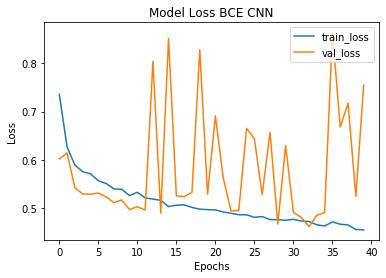

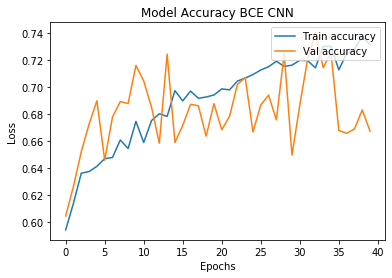

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.681358,0.917402,0.781955,0.612962,0.540428,0.667362
Confirmed,0.569038,0.202683,0.298901,0.612962,0.540428,0.667362


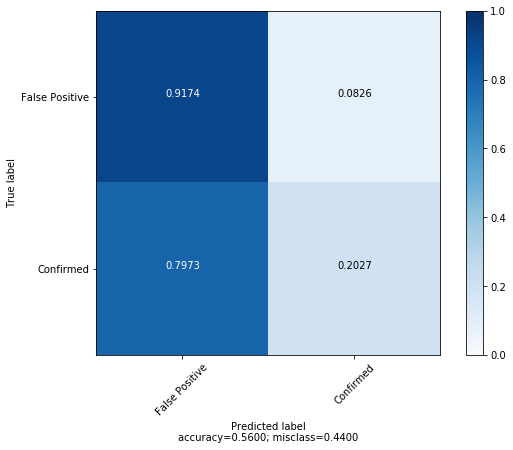

In [21]:
train_model(model, x_train, y_train, x_val, y_val, e=40) #con global pooling con BN (con dropa)

Train on 8678 samples, validate on 1918 samples
Epoch 1/40
8678/8678 [==============================] - 6s 719us/step - loss: 0.5899 - acc: 0.6251 - val_loss: 0.5544 - val_acc: 0.6502
Epoch 2/40
8678/8678 [==============================] - 4s 511us/step - loss: 0.5647 - acc: 0.6289 - val_loss: 0.5552 - val_acc: 0.6502
Epoch 3/40
8678/8678 [==============================] - 5s 568us/step - loss: 0.5587 - acc: 0.6289 - val_loss: 0.5480 - val_acc: 0.6502
Epoch 4/40
8678/8678 [==============================] - 5s 577us/step - loss: 0.5505 - acc: 0.6293 - val_loss: 0.5393 - val_acc: 0.6502
Epoch 5/40
8678/8678 [==============================] - 5s 540us/step - loss: 0.5470 - acc: 0.6247 - val_loss: 0.5403 - val_acc: 0.6293
Epoch 6/40
8678/8678 [==============================] - 5s 527us/step - loss: 0.5395 - acc: 0.6265 - val_loss: 0.5298 - val_acc: 0.6397
Epoch 7/40
8678/8678 [==============================] - 5s 560us/step - loss: 0.5315 - acc: 0.6382 - val_loss: 0.5238 - val_acc: 0.6434


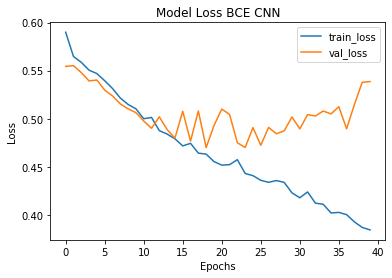

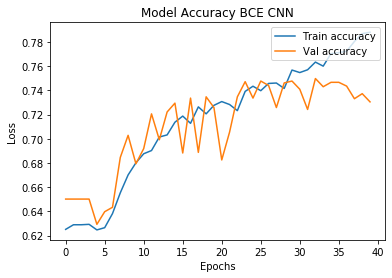

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.803156,0.775461,0.789066,0.732268,0.70789,0.730448
Confirmed,0.607843,0.646796,0.626715,0.732268,0.70789,0.730448


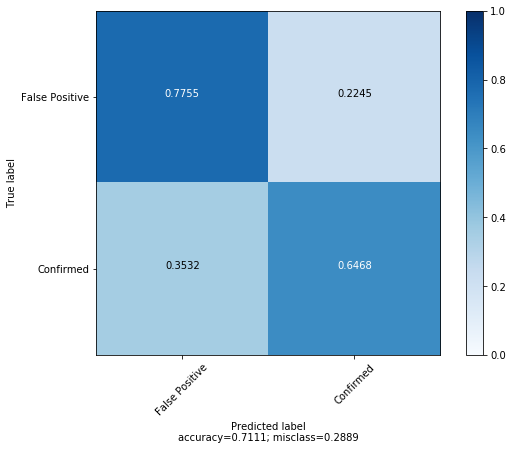

In [17]:
train_model(model, x_train, y_train, x_val, y_val, e=40) #con global pooling sin dropa

### Modelo 2 (con Batch)

In [14]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), strides=(1, 1),activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (2, 2), strides=(1, 1), activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(Flatten())
#model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 43, 43, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 43, 43, 32)        128       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 41, 41, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 41, 41, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 18, 18, 64)      

Train on 9384 samples, validate on 1565 samples
Epoch 1/25
9384/9384 [==============================] - 52s 6ms/step - loss: 0.7276 - acc: 0.6115 - val_loss: 0.8024 - val_acc: 0.5093
Epoch 2/25
9384/9384 [==============================] - 47s 5ms/step - loss: 0.5960 - acc: 0.6436 - val_loss: 0.6618 - val_acc: 0.5150
Epoch 3/25
9384/9384 [==============================] - 46s 5ms/step - loss: 0.5520 - acc: 0.6674 - val_loss: 0.6471 - val_acc: 0.5367
Epoch 4/25
9384/9384 [==============================] - 44s 5ms/step - loss: 0.5323 - acc: 0.6724 - val_loss: 0.5971 - val_acc: 0.5898
Epoch 5/25
9384/9384 [==============================] - 45s 5ms/step - loss: 0.5105 - acc: 0.6903 - val_loss: 0.5779 - val_acc: 0.6000
Epoch 6/25
9384/9384 [==============================] - 47s 5ms/step - loss: 0.4968 - acc: 0.7017 - val_loss: 0.5444 - val_acc: 0.7016
Epoch 7/25
9384/9384 [==============================] - 45s 5ms/step - loss: 0.4861 - acc: 0.7041 - val_loss: 0.5904 - val_acc: 0.6307
Epoch 8

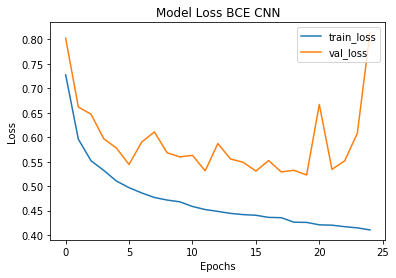

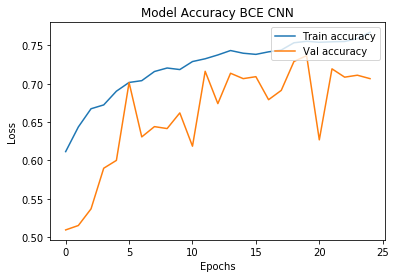

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.701273,0.987736,0.820212,0.621533,0.512359,0.706709
Confirmed,0.819444,0.116832,0.204506,0.621533,0.512359,0.706709


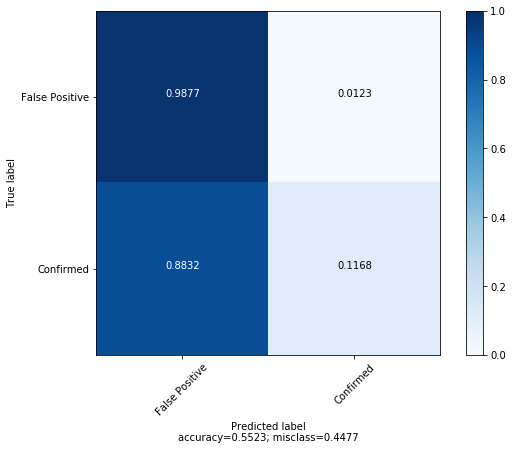

In [62]:
train_model(model, x_train, y_train, x_val, y_val, e=25)

Train on 8678 samples, validate on 1918 samples
Epoch 1/40
8678/8678 [==============================] - 28s 3ms/step - loss: 0.7534 - acc: 0.5976 - val_loss: 0.6479 - val_acc: 0.6157
Epoch 2/40
8678/8678 [==============================] - 27s 3ms/step - loss: 0.6183 - acc: 0.6254 - val_loss: 0.7199 - val_acc: 0.6084
Epoch 3/40
8678/8678 [==============================] - 36s 4ms/step - loss: 0.5834 - acc: 0.6369 - val_loss: 0.5219 - val_acc: 0.6950
Epoch 4/40
8678/8678 [==============================] - 26s 3ms/step - loss: 0.5663 - acc: 0.6492 - val_loss: 0.5279 - val_acc: 0.6668
Epoch 5/40
8678/8678 [==============================] - 35s 4ms/step - loss: 0.5424 - acc: 0.6599 - val_loss: 0.4932 - val_acc: 0.7221
Epoch 6/40
8678/8678 [==============================] - 36s 4ms/step - loss: 0.5288 - acc: 0.6684 - val_loss: 0.4874 - val_acc: 0.7284
Epoch 7/40
8678/8678 [==============================] - 39s 5ms/step - loss: 0.5241 - acc: 0.6741 - val_loss: 0.4842 - val_acc: 0.7247
Epoch 8

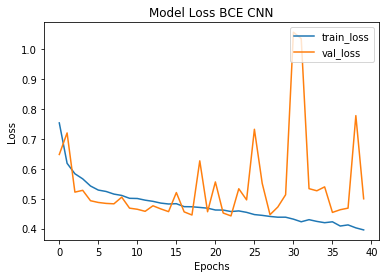

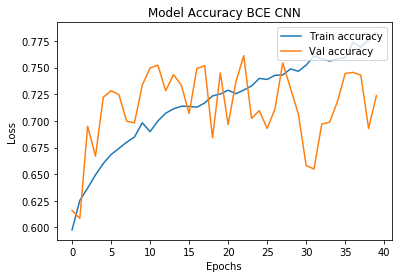

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.864700,0.681636,0.762332,0.730026,0.71616,0.72367
Confirmed,0.575401,0.801788,0.669988,0.730026,0.71616,0.72367


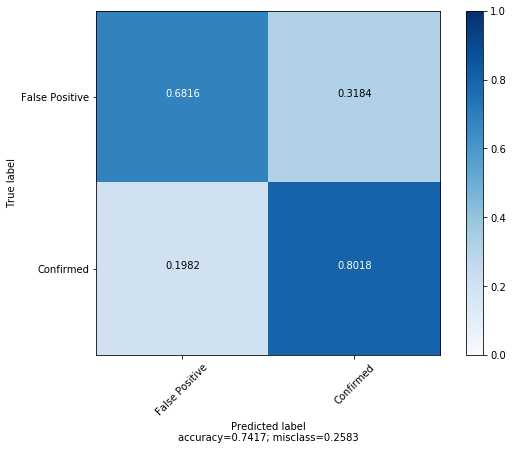

In [15]:
train_model(model, x_train, y_train, x_val, y_val, e=40) #old test

### Modelo 4

In [8]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
#model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
#model.add(Dropout(0.25))

#model.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(Flatten())
#model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 43, 43, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2592)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               331904    


Train on 8678 samples, validate on 1918 samples
Epoch 1/25
8678/8678 [==============================] - 7s 792us/step - loss: 0.5861 - acc: 0.6187 - val_loss: 0.5417 - val_acc: 0.6502
Epoch 2/25
8678/8678 [==============================] - 3s 337us/step - loss: 0.5455 - acc: 0.6225 - val_loss: 0.5335 - val_acc: 0.6554
Epoch 3/25
8678/8678 [==============================] - 2s 261us/step - loss: 0.5395 - acc: 0.6326 - val_loss: 0.5278 - val_acc: 0.6595
Epoch 4/25
8678/8678 [==============================] - 2s 268us/step - loss: 0.5352 - acc: 0.6409 - val_loss: 0.5273 - val_acc: 0.6726
Epoch 5/25
8678/8678 [==============================] - 2s 278us/step - loss: 0.5301 - acc: 0.6518 - val_loss: 0.5207 - val_acc: 0.6700
Epoch 6/25
8678/8678 [==============================] - 2s 255us/step - loss: 0.5264 - acc: 0.6561 - val_loss: 0.5164 - val_acc: 0.6976
Epoch 7/25
8678/8678 [==============================] - 3s 336us/step - loss: 0.5247 - acc: 0.6617 - val_loss: 0.5146 - val_acc: 0.6851


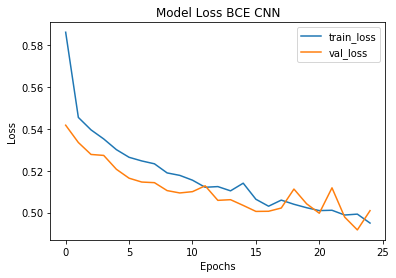

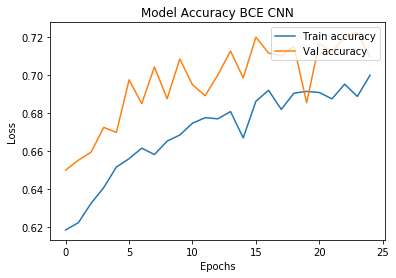

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.815934,0.714515,0.761864,0.715005,0.694893,0.709593
Confirmed,0.569007,0.700447,0.627923,0.715005,0.694893,0.709593


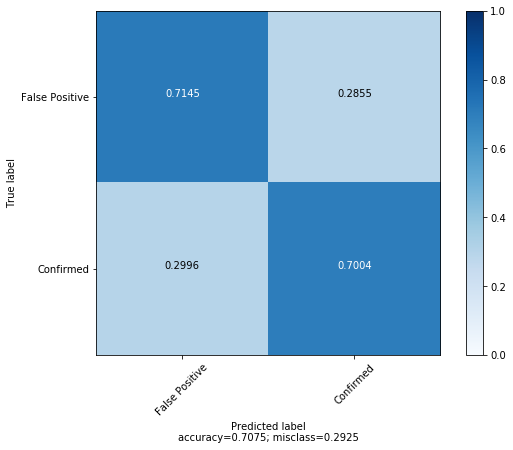

In [74]:
train_model(model, x_train, y_train, x_val, y_val, e=25) #old test

Train on 8678 samples, validate on 1918 samples
Epoch 1/40
8678/8678 [==============================] - 3s 323us/step - loss: 0.5822 - acc: 0.6231 - val_loss: 0.5421 - val_acc: 0.6309
Epoch 2/40
8678/8678 [==============================] - 2s 205us/step - loss: 0.5469 - acc: 0.6394 - val_loss: 0.5304 - val_acc: 0.6533
Epoch 3/40
8678/8678 [==============================] - 2s 217us/step - loss: 0.5356 - acc: 0.6446 - val_loss: 0.5205 - val_acc: 0.6705
Epoch 4/40
8678/8678 [==============================] - 2s 262us/step - loss: 0.5287 - acc: 0.6616 - val_loss: 0.5180 - val_acc: 0.6919
Epoch 5/40
8678/8678 [==============================] - 2s 233us/step - loss: 0.5274 - acc: 0.6616 - val_loss: 0.5128 - val_acc: 0.6997
Epoch 6/40
8678/8678 [==============================] - 2s 243us/step - loss: 0.5209 - acc: 0.6681 - val_loss: 0.5095 - val_acc: 0.7075
Epoch 7/40
8678/8678 [==============================] - 2s 225us/step - loss: 0.5148 - acc: 0.6737 - val_loss: 0.5097 - val_acc: 0.7049


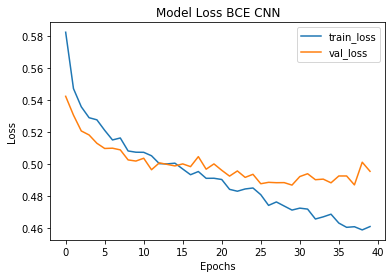

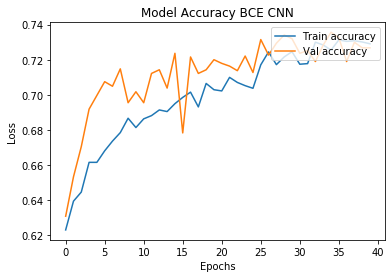

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.783975,0.800321,0.792063,0.725509,0.696944,0.726799
Confirmed,0.613953,0.590164,0.601824,0.725509,0.696944,0.726799


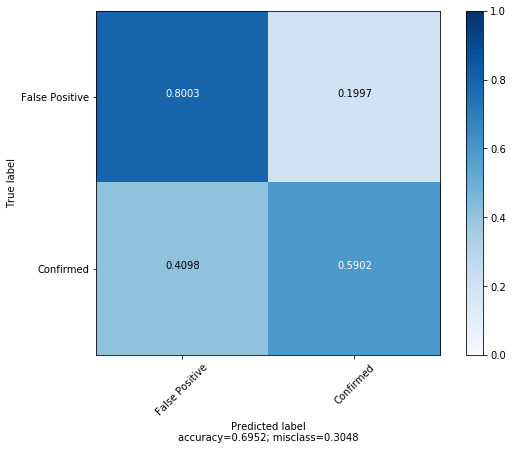

In [9]:
train_model(model, x_train, y_train, x_val, y_val, e=40) #old test

Train on 8678 samples, validate on 1918 samples
Epoch 1/200
8678/8678 [==============================] - 2s 192us/step - loss: 0.4514 - acc: 0.7427 - val_loss: 0.4909 - val_acc: 0.7351
Epoch 2/200
8678/8678 [==============================] - 2s 211us/step - loss: 0.4481 - acc: 0.7365 - val_loss: 0.4890 - val_acc: 0.7393
Epoch 3/200
8678/8678 [==============================] - 2s 198us/step - loss: 0.4454 - acc: 0.7495 - val_loss: 0.4974 - val_acc: 0.7195
Epoch 4/200
8678/8678 [==============================] - 2s 205us/step - loss: 0.4492 - acc: 0.7425 - val_loss: 0.4917 - val_acc: 0.7263
Epoch 5/200
8678/8678 [==============================] - 2s 185us/step - loss: 0.4435 - acc: 0.7526 - val_loss: 0.5003 - val_acc: 0.7153
Epoch 6/200
8678/8678 [==============================] - 2s 206us/step - loss: 0.4426 - acc: 0.7502 - val_loss: 0.4872 - val_acc: 0.7278
Epoch 7/200
8678/8678 [==============================] - 2s 206us/step - loss: 0.4409 - acc: 0.7534 - val_loss: 0.4897 - val_acc: 

8678/8678 [==============================] - 2s 193us/step - loss: 0.2454 - acc: 0.8873 - val_loss: 0.6181 - val_acc: 0.7450
Epoch 61/200
8678/8678 [==============================] - 2s 201us/step - loss: 0.2488 - acc: 0.8909 - val_loss: 0.6132 - val_acc: 0.7336
Epoch 62/200
8678/8678 [==============================] - 2s 194us/step - loss: 0.2403 - acc: 0.8933 - val_loss: 0.6383 - val_acc: 0.7388
Epoch 63/200
8678/8678 [==============================] - 2s 174us/step - loss: 0.2336 - acc: 0.8957 - val_loss: 0.6390 - val_acc: 0.7383
Epoch 64/200
8678/8678 [==============================] - 2s 188us/step - loss: 0.2333 - acc: 0.8959 - val_loss: 0.6407 - val_acc: 0.7331
Epoch 65/200
8678/8678 [==============================] - 2s 187us/step - loss: 0.2245 - acc: 0.9029 - val_loss: 0.6596 - val_acc: 0.7497
Epoch 66/200
8678/8678 [==============================] - 2s 192us/step - loss: 0.2237 - acc: 0.9052 - val_loss: 0.6684 - val_acc: 0.7341
Epoch 67/200
8678/8678 [=======================

8678/8678 [==============================] - 2s 215us/step - loss: 0.0392 - acc: 0.9882 - val_loss: 1.5445 - val_acc: 0.7357
Epoch 179/200
8678/8678 [==============================] - 4s 415us/step - loss: 0.0459 - acc: 0.9834 - val_loss: 1.5634 - val_acc: 0.7263
Epoch 180/200
8678/8678 [==============================] - 2s 224us/step - loss: 0.0389 - acc: 0.9865 - val_loss: 1.5946 - val_acc: 0.7304
Epoch 181/200
8678/8678 [==============================] - 4s 408us/step - loss: 0.0425 - acc: 0.9863 - val_loss: 1.6320 - val_acc: 0.7258
Epoch 182/200
8678/8678 [==============================] - 4s 408us/step - loss: 0.0392 - acc: 0.9864 - val_loss: 1.6232 - val_acc: 0.7419
Epoch 183/200
8678/8678 [==============================] - 2s 235us/step - loss: 0.0318 - acc: 0.9909 - val_loss: 1.8107 - val_acc: 0.7325
Epoch 184/200
8678/8678 [==============================] - 2s 219us/step - loss: 0.0424 - acc: 0.9859 - val_loss: 1.6540 - val_acc: 0.7237
Epoch 185/200
8678/8678 [================

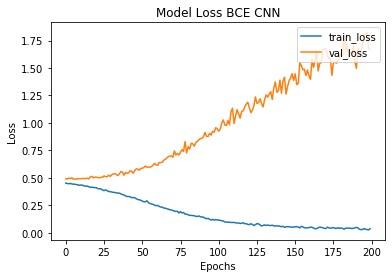

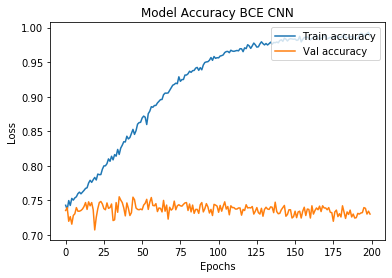

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.805021,0.771451,0.787879,0.732089,0.708143,0.729927
Confirmed,0.605809,0.652757,0.628407,0.732089,0.708143,0.729927


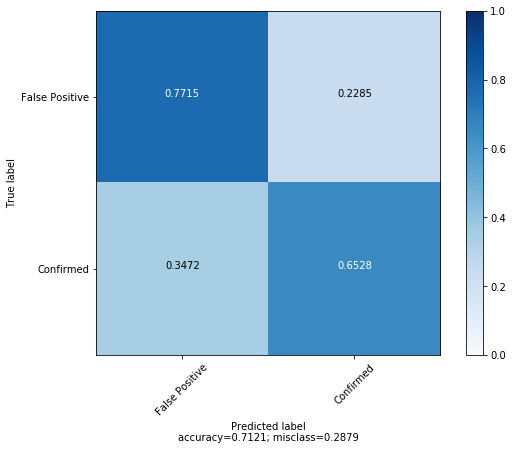

In [10]:
train_model(model, x_train, y_train, x_val, y_val, e=200) #old test

In [20]:
## experimetanciones varias -- modelo 1
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
#model.add(BatchNormalization())
#model.add(Conv2D(32, (3, 3), strides=(1, 1),activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
#model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
#model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
#model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
#model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
#model.add(MaxPooling2D((2,2)))
#model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 43, 43, 32)        320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 19, 19, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 5, 5, 256)         295168    
_________________________________________________________________
global_average_pooling2d_2 ( (None, 256)              

Train on 8678 samples, validate on 1918 samples
Epoch 1/40
8678/8678 [==============================] - 8s 918us/step - loss: 0.5955 - acc: 0.6251 - val_loss: 0.5648 - val_acc: 0.6502
Epoch 2/40
8678/8678 [==============================] - 6s 722us/step - loss: 0.5661 - acc: 0.6289 - val_loss: 0.5532 - val_acc: 0.6502
Epoch 3/40
8678/8678 [==============================] - 6s 725us/step - loss: 0.5633 - acc: 0.6291 - val_loss: 0.5556 - val_acc: 0.6502
Epoch 4/40
8678/8678 [==============================] - 6s 698us/step - loss: 0.5615 - acc: 0.6286 - val_loss: 0.5573 - val_acc: 0.6502
Epoch 5/40
8678/8678 [==============================] - 6s 711us/step - loss: 0.5569 - acc: 0.6289 - val_loss: 0.5483 - val_acc: 0.6502
Epoch 6/40
8678/8678 [==============================] - 6s 717us/step - loss: 0.5595 - acc: 0.6227 - val_loss: 0.5759 - val_acc: 0.6502
Epoch 7/40
8678/8678 [==============================] - 6s 675us/step - loss: 0.5564 - acc: 0.6271 - val_loss: 0.5476 - val_acc: 0.6220


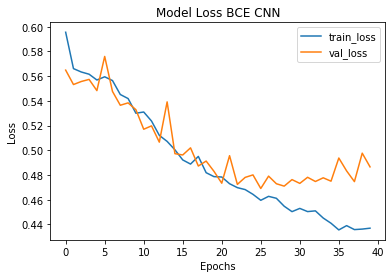

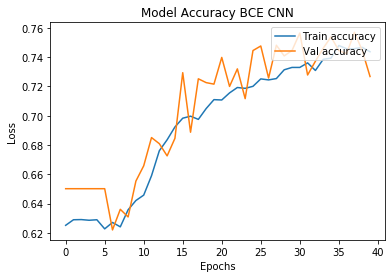

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.796555,0.778669,0.787510,0.72804,0.702514,0.726799
Confirmed,0.605150,0.630402,0.617518,0.72804,0.702514,0.726799


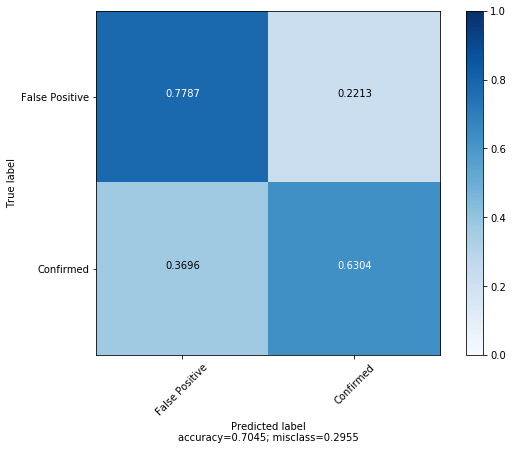

In [21]:
train_model(model, x_train, y_train, x_val, y_val, e=40) #old test

In [ ]:
* sin dropa-- ña
* sin double --ayuda a regularizar (mas simple)
* con bn? -- no


In [29]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (2, 2), strides=(1, 1), activation="relu", padding="valid"))
#model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 43, 43, 32)        320       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 19, 19, 64)        18496     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 7, 7, 128)       

Train on 8678 samples, validate on 1918 samples
Epoch 1/100
8678/8678 [==============================] - 12s 1ms/step - loss: 0.6013 - acc: 0.6286 - val_loss: 0.5590 - val_acc: 0.6502
Epoch 2/100
8678/8678 [==============================] - 6s 682us/step - loss: 0.5690 - acc: 0.6289 - val_loss: 0.5589 - val_acc: 0.6502
Epoch 3/100
8678/8678 [==============================] - 6s 676us/step - loss: 0.5654 - acc: 0.6289 - val_loss: 0.5573 - val_acc: 0.6502
Epoch 4/100
8678/8678 [==============================] - 6s 688us/step - loss: 0.5646 - acc: 0.6289 - val_loss: 0.5499 - val_acc: 0.6502
Epoch 5/100
8678/8678 [==============================] - 6s 698us/step - loss: 0.5573 - acc: 0.6286 - val_loss: 0.5543 - val_acc: 0.6502
Epoch 6/100
8678/8678 [==============================] - 6s 644us/step - loss: 0.5575 - acc: 0.6289 - val_loss: 0.5414 - val_acc: 0.6502
Epoch 7/100
8678/8678 [==============================] - 6s 682us/step - loss: 0.5557 - acc: 0.6292 - val_loss: 0.5442 - val_acc: 0

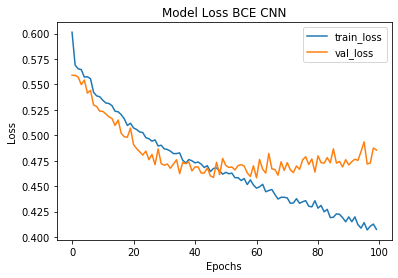

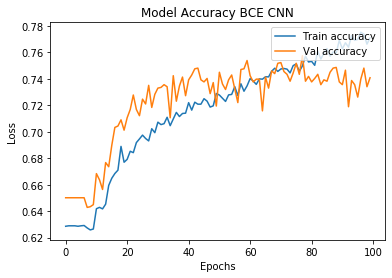

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.761872,0.874900,0.814483,0.729106,0.692462,0.740876
Confirmed,0.679012,0.491803,0.570441,0.729106,0.692462,0.740876


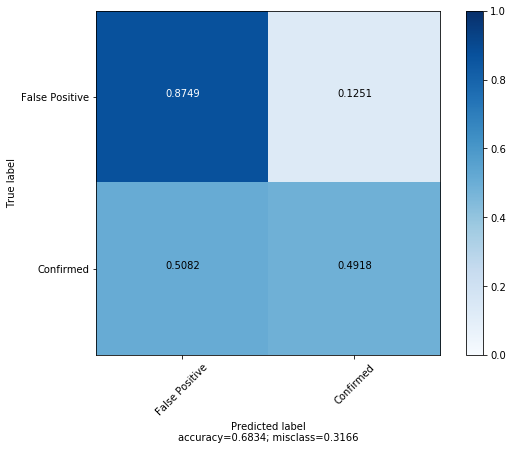

In [30]:
train_model(model, x_train, y_train, x_val, y_val, e=100) #modelo 2 sin double sin BN

In [116]:
#rnn por fila luego  cnn

model = Sequential()
model.add(InputLayer(input_shape=x_train.shape[1:]))
#model.add(Lambda(lambda x: K.squeeze(x, axis=-1)))

model.add(TimeDistributed(GRU(32, activation='relu', return_sequences=True)))
model.add(Dropout(0.2))
model.add(TimeDistributed(GRU(32, activation='relu', return_sequences=False)))
model.add(Dropout(0.2))

model.add(Lambda(lambda x: K.expand_dims(x, axis=-1)))
model.add(Conv2D(16, (3, 3), strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))


model.add(Flatten())
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_20 (TimeDis (None, 45, 45, 32)        3264      
_________________________________________________________________
dropout_100 (Dropout)        (None, 45, 45, 32)        0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 45, 32)            6240      
_________________________________________________________________
dropout_101 (Dropout)        (None, 45, 32)            0         
_________________________________________________________________
lambda_8 (Lambda)            (None, 45, 32, 1)         0         
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 43, 30, 16)        160       
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 21, 15, 16)      

In [117]:
train_model(model, x_train, y_train, x_val, y_val, e=25) #old test

Train on 8678 samples, validate on 1918 samples
Epoch 1/25
 384/8678 [>.............................] - ETA: 4:45 - loss: 0.6926 - acc: 0.5885

KeyboardInterrupt: 

In [ ]:
##skip connection
https://stackoverflow.com/questions/42384602/implementing-skip-connections-in-keras

## mejor modelo con focal loss

In [118]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)#{0: 3.,   1: 6.,   2: 5.,  3: 3.}
print (class_weights)

[0.79497985 1.34751553]


In [22]:
import tensorflow as tf
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

In [37]:
## experimetanciones varias -- modelo 1
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="valid"))

model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss=binary_focal_loss(alpha=0.6, gamma=2),optimizer='Adam',metrics=['accuracy'])
#model.compile(loss=binary_focal_loss(alpha=.25, gamma=2),optimizer='Adam',metrics=['accuracy'])

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 43, 43, 32)        320       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 19, 19, 64)        18496     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 1, 1, 256)       

Train on 8678 samples, validate on 1918 samples
Epoch 1/25
8678/8678 [==============================] - 10s 1ms/step - loss: 7.8582 - acc: 0.6272 - val_loss: 7.2536 - val_acc: 0.6502
Epoch 2/25
8678/8678 [==============================] - 4s 505us/step - loss: 7.4764 - acc: 0.6289 - val_loss: 7.2686 - val_acc: 0.6502
Epoch 3/25
8678/8678 [==============================] - 5s 532us/step - loss: 7.4217 - acc: 0.6289 - val_loss: 7.2570 - val_acc: 0.6502
Epoch 4/25
8678/8678 [==============================] - 5s 578us/step - loss: 7.4512 - acc: 0.6289 - val_loss: 7.2085 - val_acc: 0.6502
Epoch 5/25
8678/8678 [==============================] - 5s 549us/step - loss: 7.3838 - acc: 0.6289 - val_loss: 7.2265 - val_acc: 0.6502
Epoch 6/25
8678/8678 [==============================] - 5s 562us/step - loss: 7.3495 - acc: 0.6289 - val_loss: 7.1659 - val_acc: 0.6502
Epoch 7/25
8678/8678 [==============================] - 5s 539us/step - loss: 7.3308 - acc: 0.6289 - val_loss: 7.3480 - val_acc: 0.6502
E

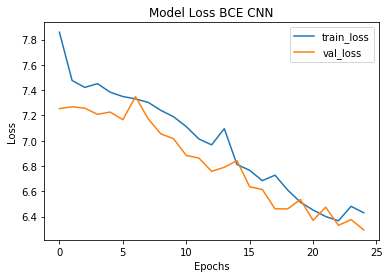

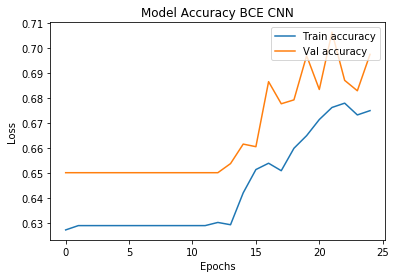

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.685175,0.989575,0.809711,0.618783,0.536835,0.697602
Confirmed,0.888889,0.154993,0.263959,0.618783,0.536835,0.697602


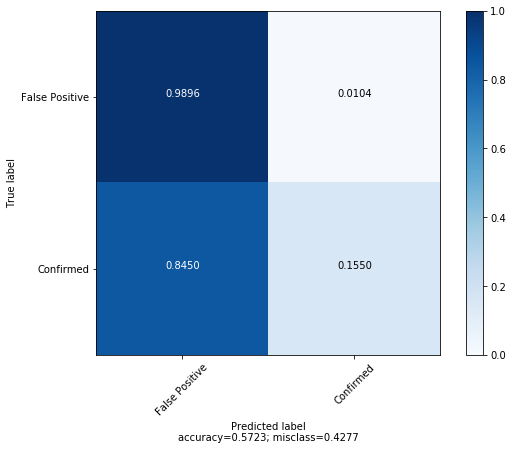

In [126]:
train_model(model, x_train, y_train, x_val, y_val, e=25) #old test

Train on 8678 samples, validate on 1918 samples
Epoch 1/40
8678/8678 [==============================] - 8s 919us/step - loss: 9.1263 - acc: 0.6102 - val_loss: 8.8737 - val_acc: 0.6215
Epoch 2/40
8678/8678 [==============================] - 5s 602us/step - loss: 8.7359 - acc: 0.6136 - val_loss: 8.6955 - val_acc: 0.5980
Epoch 3/40
8678/8678 [==============================] - 5s 609us/step - loss: 8.4822 - acc: 0.6263 - val_loss: 8.3619 - val_acc: 0.6303
Epoch 4/40
8678/8678 [==============================] - 5s 602us/step - loss: 8.2997 - acc: 0.6372 - val_loss: 8.3778 - val_acc: 0.6444
Epoch 5/40
8678/8678 [==============================] - 5s 584us/step - loss: 8.2308 - acc: 0.6369 - val_loss: 8.2992 - val_acc: 0.6491
Epoch 6/40
8678/8678 [==============================] - 5s 572us/step - loss: 8.1035 - acc: 0.6442 - val_loss: 8.2720 - val_acc: 0.6210
Epoch 7/40
8678/8678 [==============================] - 5s 564us/step - loss: 8.0032 - acc: 0.6457 - val_loss: 8.0358 - val_acc: 0.6585


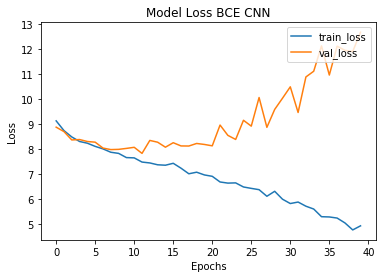

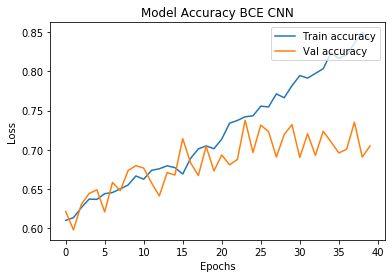

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.838806,0.676022,0.748668,0.711588,0.695672,0.704901
Confirmed,0.557503,0.758569,0.642677,0.711588,0.695672,0.704901


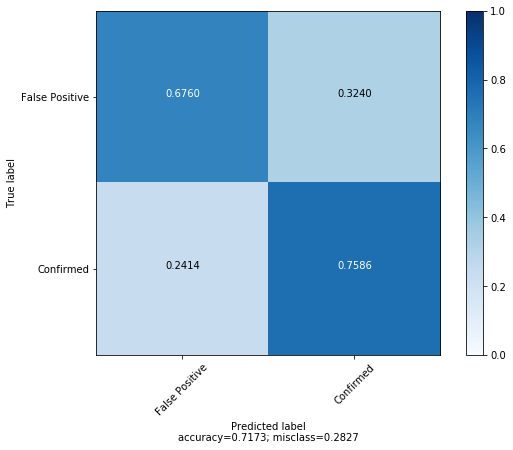

In [38]:
train_model(model, x_train, y_train, x_val, y_val, e=40) #alpha alto

In [30]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256, (2, 2), strides=(1, 1), activation="relu", padding="valid"))
#model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss=binary_focal_loss(alpha=0.65, gamma=2),optimizer='Adam',metrics=['accuracy'])

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 43, 43, 32)        320       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 19, 19, 64)        18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 2, 2, 256)       

Train on 8678 samples, validate on 1918 samples
Epoch 1/40
8678/8678 [==============================] - 7s 816us/step - loss: 9.1458 - acc: 0.6072 - val_loss: 8.8507 - val_acc: 0.6001
Epoch 2/40
8678/8678 [==============================] - 4s 499us/step - loss: 8.8724 - acc: 0.6058 - val_loss: 8.8238 - val_acc: 0.5876
Epoch 3/40
8678/8678 [==============================] - 4s 465us/step - loss: 8.7931 - acc: 0.6091 - val_loss: 8.6164 - val_acc: 0.6220
Epoch 4/40
8678/8678 [==============================] - 4s 496us/step - loss: 8.6192 - acc: 0.6136 - val_loss: 8.4468 - val_acc: 0.6267
Epoch 5/40
8678/8678 [==============================] - 5s 558us/step - loss: 8.4712 - acc: 0.6291 - val_loss: 8.4116 - val_acc: 0.6246
Epoch 6/40
8678/8678 [==============================] - 5s 600us/step - loss: 8.3290 - acc: 0.6338 - val_loss: 8.4866 - val_acc: 0.6413
Epoch 7/40
8678/8678 [==============================] - 5s 550us/step - loss: 8.2556 - acc: 0.6383 - val_loss: 8.3096 - val_acc: 0.6230


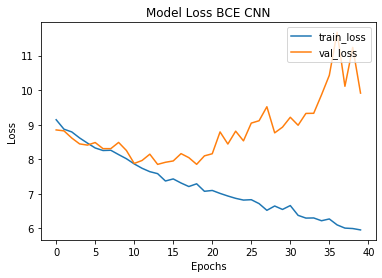

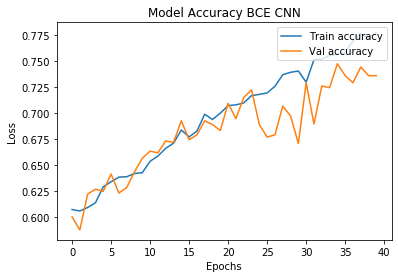

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.811973,0.772253,0.791615,0.738095,0.715123,0.735662
Confirmed,0.612022,0.667660,0.638632,0.738095,0.715123,0.735662


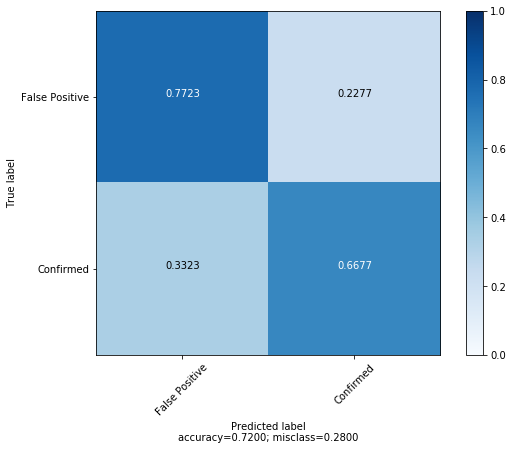

In [24]:
train_model(model, x_train, y_train, x_val, y_val, e=40) #alpha 0.6

Train on 8678 samples, validate on 1918 samples
Epoch 1/40
8678/8678 [==============================] - 7s 848us/step - loss: 8.8709 - acc: 0.5982 - val_loss: 8.5833 - val_acc: 0.5923
Epoch 2/40
8678/8678 [==============================] - 5s 543us/step - loss: 8.5931 - acc: 0.6036 - val_loss: 8.4192 - val_acc: 0.6074
Epoch 3/40
8678/8678 [==============================] - 5s 529us/step - loss: 8.3736 - acc: 0.6164 - val_loss: 8.2326 - val_acc: 0.6168
Epoch 4/40
8678/8678 [==============================] - 5s 544us/step - loss: 8.2544 - acc: 0.6211 - val_loss: 8.5717 - val_acc: 0.6309
Epoch 5/40
8678/8678 [==============================] - 4s 511us/step - loss: 8.1764 - acc: 0.6240 - val_loss: 8.1699 - val_acc: 0.6189
Epoch 6/40
8678/8678 [==============================] - 5s 537us/step - loss: 7.9522 - acc: 0.6355 - val_loss: 8.1196 - val_acc: 0.6074
Epoch 7/40
8678/8678 [==============================] - 5s 563us/step - loss: 7.8664 - acc: 0.6356 - val_loss: 7.8197 - val_acc: 0.6434


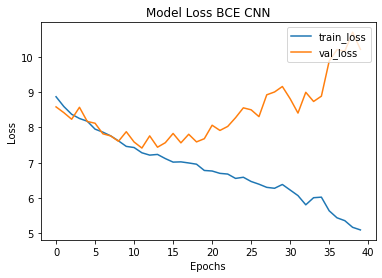

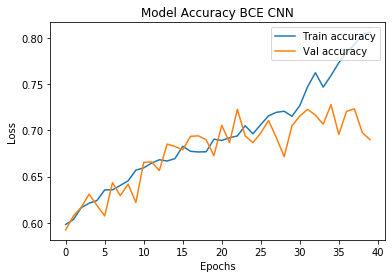

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.899510,0.588613,0.711585,0.695081,0.687998,0.689781
Confirmed,0.534483,0.877794,0.664411,0.695081,0.687998,0.689781


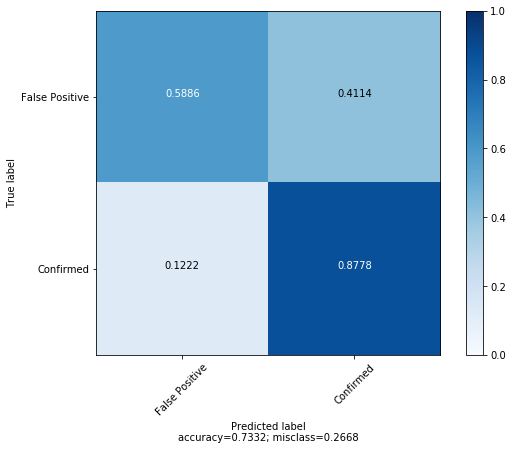

In [31]:
train_model(model, x_train, y_train, x_val, y_val, e=40) #alpha 0.65

### Concat

In [22]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256, (2, 2), strides=(1, 1), activation="relu", padding="valid"))
#model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss=binary_focal_loss(alpha=0.6, gamma=2),optimizer='Adam',metrics=['accuracy'])
#model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 43, 43, 32)        608       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 19, 19, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 2, 2, 256)        

NameError: name 'binary_focal_loss' is not defined

Train on 4339 samples, validate on 1918 samples
Epoch 1/40
4339/4339 [==============================] - 3s 616us/step - loss: 0.6113 - acc: 0.6253 - val_loss: 0.5596 - val_acc: 0.6502
Epoch 2/40
4339/4339 [==============================] - 1s 276us/step - loss: 0.5706 - acc: 0.6289 - val_loss: 0.5578 - val_acc: 0.6502
Epoch 3/40
4339/4339 [==============================] - 1s 303us/step - loss: 0.5636 - acc: 0.6289 - val_loss: 0.5558 - val_acc: 0.6502
Epoch 4/40
4339/4339 [==============================] - 1s 307us/step - loss: 0.5638 - acc: 0.6289 - val_loss: 0.5514 - val_acc: 0.6502
Epoch 5/40
4339/4339 [==============================] - 1s 305us/step - loss: 0.5628 - acc: 0.6289 - val_loss: 0.5525 - val_acc: 0.6502
Epoch 6/40
4339/4339 [==============================] - 1s 297us/step - loss: 0.5570 - acc: 0.6315 - val_loss: 0.5482 - val_acc: 0.6502
Epoch 7/40
4339/4339 [==============================] - 1s 290us/step - loss: 0.5562 - acc: 0.6299 - val_loss: 0.5480 - val_acc: 0.6502


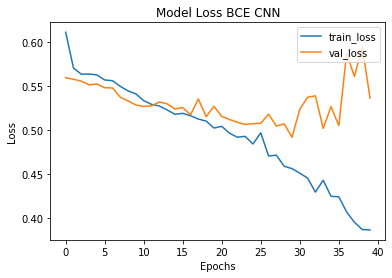

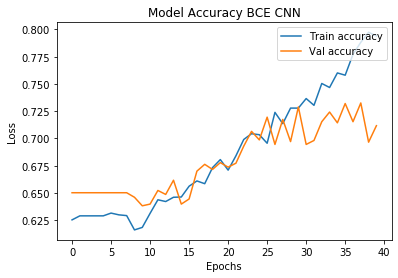

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.768161,0.797113,0.782369,0.709113,0.677671,0.711679
Confirmed,0.594551,0.552906,0.572973,0.709113,0.677671,0.711679


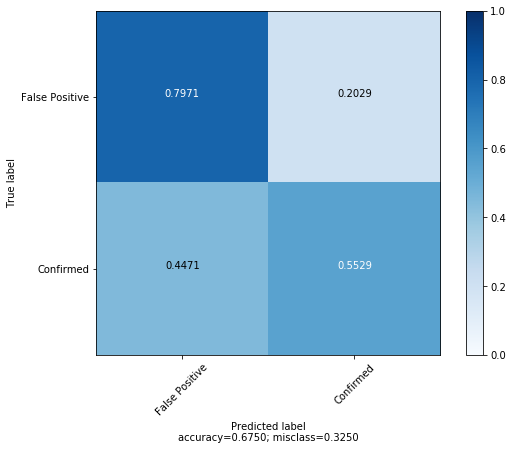

In [21]:
train_model(model, x_train, y_train, x_val, y_val, e=40) #sin focal

In [ ]:
train_model(model, x_train, y_train, x_val, y_val, e=40) #alpha 0.6

In [27]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
#model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
#model.add(Dropout(0.25))

#model.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(Flatten())
#model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 28, 28, 32)        608       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               147584    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)              

Train on 4339 samples, validate on 1918 samples
Epoch 1/40
4339/4339 [==============================] - 2s 507us/step - loss: 0.6026 - acc: 0.6241 - val_loss: 0.5508 - val_acc: 0.6194
Epoch 2/40
4339/4339 [==============================] - 2s 488us/step - loss: 0.5548 - acc: 0.6234 - val_loss: 0.5411 - val_acc: 0.6350
Epoch 3/40
4339/4339 [==============================] - 2s 471us/step - loss: 0.5464 - acc: 0.6315 - val_loss: 0.5376 - val_acc: 0.6502
Epoch 4/40
4339/4339 [==============================] - 2s 462us/step - loss: 0.5391 - acc: 0.6439 - val_loss: 0.5299 - val_acc: 0.6632
Epoch 5/40
4339/4339 [==============================] - 2s 449us/step - loss: 0.5371 - acc: 0.6345 - val_loss: 0.5279 - val_acc: 0.6700
Epoch 6/40
4339/4339 [==============================] - 2s 474us/step - loss: 0.5333 - acc: 0.6361 - val_loss: 0.5260 - val_acc: 0.6611
Epoch 7/40
4339/4339 [==============================] - 2s 445us/step - loss: 0.5300 - acc: 0.6402 - val_loss: 0.5196 - val_acc: 0.6721


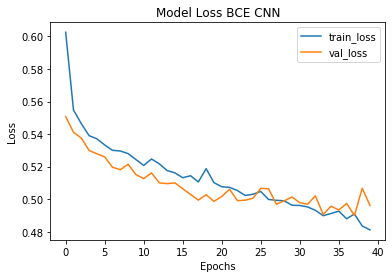

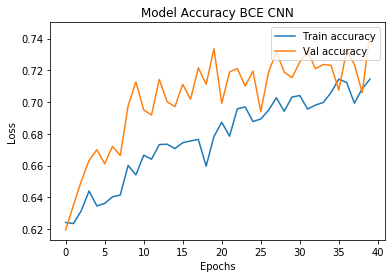

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.779586,0.845229,0.811081,0.73831,0.707077,0.744004
Confirmed,0.659011,0.555887,0.603072,0.73831,0.707077,0.744004


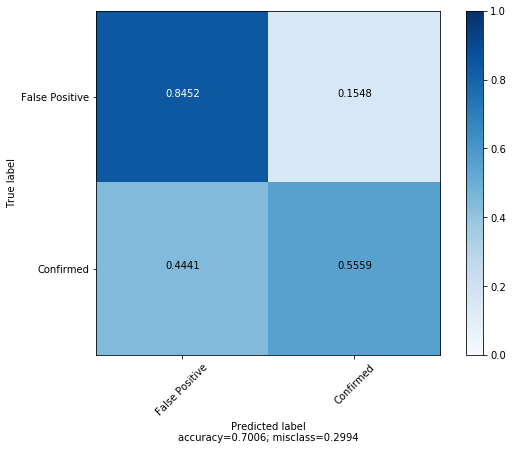

In [15]:
train_model(model, x_train, y_train, x_val, y_val, e=40) #sin focal

Train on 4339 samples, validate on 1918 samples
Epoch 1/200
4339/4339 [==============================] - 1s 235us/step - loss: 0.4848 - acc: 0.7089 - val_loss: 0.4919 - val_acc: 0.7158
Epoch 2/200
4339/4339 [==============================] - 1s 218us/step - loss: 0.4809 - acc: 0.7131 - val_loss: 0.4967 - val_acc: 0.7273
Epoch 3/200
4339/4339 [==============================] - 1s 223us/step - loss: 0.4791 - acc: 0.7138 - val_loss: 0.5039 - val_acc: 0.7393
Epoch 4/200
4339/4339 [==============================] - 1s 236us/step - loss: 0.4808 - acc: 0.7191 - val_loss: 0.4947 - val_acc: 0.7205
Epoch 5/200
4339/4339 [==============================] - 2s 467us/step - loss: 0.4792 - acc: 0.7156 - val_loss: 0.4920 - val_acc: 0.7164
Epoch 6/200
4339/4339 [==============================] - 2s 431us/step - loss: 0.4738 - acc: 0.7174 - val_loss: 0.4891 - val_acc: 0.7294
Epoch 7/200
4339/4339 [==============================] - 1s 246us/step - loss: 0.4721 - acc: 0.7227 - val_loss: 0.5008 - val_acc: 

4339/4339 [==============================] - 1s 229us/step - loss: 0.3176 - acc: 0.8626 - val_loss: 0.5498 - val_acc: 0.7409
Epoch 61/200
4339/4339 [==============================] - 1s 250us/step - loss: 0.3135 - acc: 0.8569 - val_loss: 0.5336 - val_acc: 0.7377
Epoch 62/200
4339/4339 [==============================] - 1s 298us/step - loss: 0.3100 - acc: 0.8645 - val_loss: 0.5362 - val_acc: 0.7362
Epoch 63/200
4339/4339 [==============================] - 1s 249us/step - loss: 0.3038 - acc: 0.8702 - val_loss: 0.5430 - val_acc: 0.7341
Epoch 64/200
4339/4339 [==============================] - 1s 240us/step - loss: 0.3019 - acc: 0.8661 - val_loss: 0.5434 - val_acc: 0.7393
Epoch 65/200
4339/4339 [==============================] - 1s 244us/step - loss: 0.3007 - acc: 0.8705 - val_loss: 0.5473 - val_acc: 0.7388
Epoch 66/200
4339/4339 [==============================] - 2s 434us/step - loss: 0.3039 - acc: 0.8640 - val_loss: 0.5323 - val_acc: 0.7273
Epoch 67/200
4339/4339 [=======================

4339/4339 [==============================] - 1s 232us/step - loss: 0.0198 - acc: 0.9972 - val_loss: 1.3264 - val_acc: 0.7273
Epoch 179/200
4339/4339 [==============================] - 2s 446us/step - loss: 0.0173 - acc: 0.9977 - val_loss: 1.3732 - val_acc: 0.7320
Epoch 180/200
4339/4339 [==============================] - 2s 446us/step - loss: 0.0146 - acc: 0.9995 - val_loss: 1.3772 - val_acc: 0.7278
Epoch 181/200
4339/4339 [==============================] - 2s 435us/step - loss: 0.0160 - acc: 0.9979 - val_loss: 1.3347 - val_acc: 0.7278
Epoch 182/200
4339/4339 [==============================] - 2s 428us/step - loss: 0.0157 - acc: 0.9988 - val_loss: 1.4010 - val_acc: 0.7294
Epoch 183/200
4339/4339 [==============================] - 1s 221us/step - loss: 0.0171 - acc: 0.9970 - val_loss: 1.3372 - val_acc: 0.7242
Epoch 184/200
4339/4339 [==============================] - 1s 222us/step - loss: 0.0148 - acc: 0.9984 - val_loss: 1.3387 - val_acc: 0.7268
Epoch 185/200
4339/4339 [================

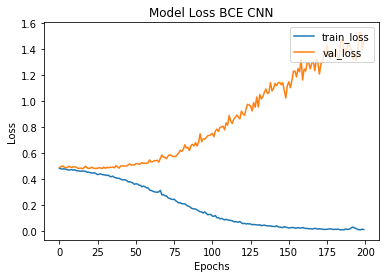

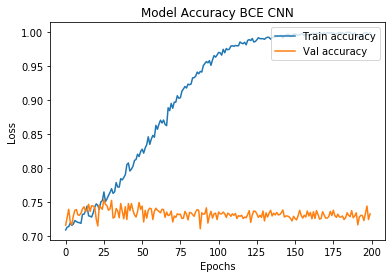

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.788976,0.803528,0.796186,0.731424,0.703627,0.732534
Confirmed,0.621914,0.600596,0.611069,0.731424,0.703627,0.732534


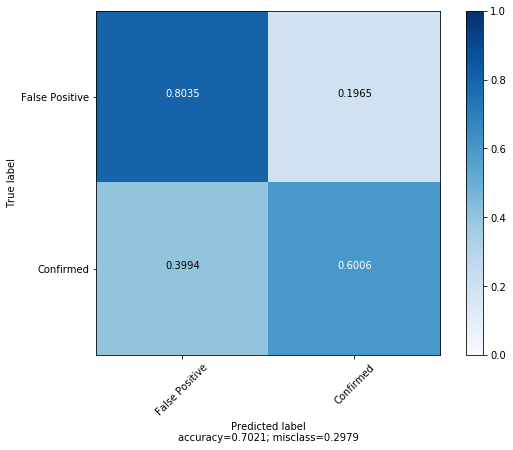

In [16]:
train_model(model, x_train, y_train, x_val, y_val, e=200) #sin focal

Train on 4339 samples, validate on 1918 samples
Epoch 1/40
4339/4339 [==============================] - 2s 429us/step - loss: 0.6099 - acc: 0.6230 - val_loss: 0.5591 - val_acc: 0.6241
Epoch 2/40
4339/4339 [==============================] - 0s 108us/step - loss: 0.5659 - acc: 0.6112 - val_loss: 0.5520 - val_acc: 0.6163
Epoch 3/40
4339/4339 [==============================] - 0s 103us/step - loss: 0.5547 - acc: 0.6283 - val_loss: 0.5462 - val_acc: 0.6272
Epoch 4/40
4339/4339 [==============================] - 1s 128us/step - loss: 0.5498 - acc: 0.6340 - val_loss: 0.5401 - val_acc: 0.6434
Epoch 5/40
4339/4339 [==============================] - 2s 351us/step - loss: 0.5444 - acc: 0.6349 - val_loss: 0.5355 - val_acc: 0.6486
Epoch 6/40
4339/4339 [==============================] - 2s 353us/step - loss: 0.5370 - acc: 0.6564 - val_loss: 0.5262 - val_acc: 0.6663
Epoch 7/40
4339/4339 [==============================] - 2s 356us/step - loss: 0.5297 - acc: 0.6637 - val_loss: 0.5214 - val_acc: 0.6689


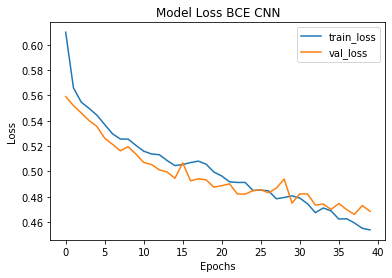

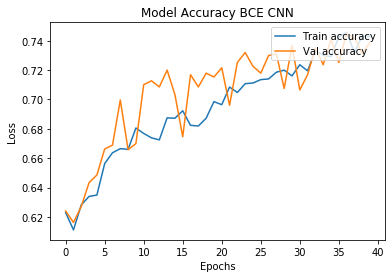

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.793239,0.809142,0.801112,0.737607,0.710351,0.73879
Confirmed,0.631579,0.608048,0.619590,0.737607,0.710351,0.73879


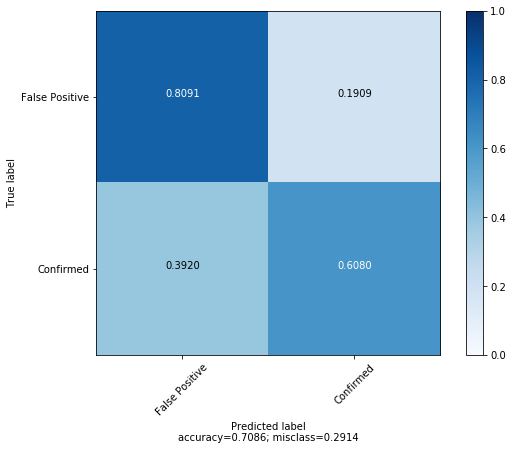

In [28]:
## matriz de 30x30
train_model(model, x_train, y_train, x_val, y_val, e=40) #sin focal

Train on 4339 samples, validate on 1918 samples
Epoch 1/200
4339/4339 [==============================] - 2s 347us/step - loss: 0.4526 - acc: 0.7476 - val_loss: 0.4648 - val_acc: 0.7497
Epoch 2/200
4339/4339 [==============================] - 1s 334us/step - loss: 0.4468 - acc: 0.7566 - val_loss: 0.5133 - val_acc: 0.7216
Epoch 3/200
4339/4339 [==============================] - 2s 350us/step - loss: 0.4529 - acc: 0.7442 - val_loss: 0.4669 - val_acc: 0.7435
Epoch 4/200
4339/4339 [==============================] - 1s 332us/step - loss: 0.4394 - acc: 0.7640 - val_loss: 0.4692 - val_acc: 0.7430
Epoch 5/200
4339/4339 [==============================] - 0s 110us/step - loss: 0.4429 - acc: 0.7562 - val_loss: 0.4640 - val_acc: 0.7503
Epoch 6/200
4339/4339 [==============================] - 0s 103us/step - loss: 0.4362 - acc: 0.7649 - val_loss: 0.4723 - val_acc: 0.7461
Epoch 7/200
4339/4339 [==============================] - 0s 99us/step - loss: 0.4309 - acc: 0.7663 - val_loss: 0.4709 - val_acc: 0

4339/4339 [==============================] - 1s 342us/step - loss: 0.0291 - acc: 0.9940 - val_loss: 1.1959 - val_acc: 0.7351
Epoch 120/200
4339/4339 [==============================] - 1s 339us/step - loss: 0.0283 - acc: 0.9931 - val_loss: 1.1757 - val_acc: 0.7336
Epoch 121/200
4339/4339 [==============================] - 1s 338us/step - loss: 0.0349 - acc: 0.9906 - val_loss: 1.1330 - val_acc: 0.7362
Epoch 122/200
4339/4339 [==============================] - 2s 348us/step - loss: 0.0282 - acc: 0.9938 - val_loss: 1.2229 - val_acc: 0.7341
Epoch 123/200
4339/4339 [==============================] - 1s 339us/step - loss: 0.0302 - acc: 0.9922 - val_loss: 1.2491 - val_acc: 0.7299
Epoch 124/200
4339/4339 [==============================] - 1s 337us/step - loss: 0.0460 - acc: 0.9857 - val_loss: 1.1327 - val_acc: 0.7357
Epoch 125/200
4339/4339 [==============================] - 1s 336us/step - loss: 0.0611 - acc: 0.9779 - val_loss: 1.2232 - val_acc: 0.7263
Epoch 126/200
4339/4339 [================

4339/4339 [==============================] - 1s 340us/step - loss: 0.0143 - acc: 0.9968 - val_loss: 1.4490 - val_acc: 0.7284
Epoch 179/200
4339/4339 [==============================] - 1s 337us/step - loss: 0.0151 - acc: 0.9954 - val_loss: 1.4605 - val_acc: 0.7346
Epoch 180/200
4339/4339 [==============================] - 1s 334us/step - loss: 0.0227 - acc: 0.9926 - val_loss: 1.4466 - val_acc: 0.7263
Epoch 181/200
4339/4339 [==============================] - 1s 344us/step - loss: 0.0150 - acc: 0.9963 - val_loss: 1.5689 - val_acc: 0.7357
Epoch 182/200
4339/4339 [==============================] - 1s 343us/step - loss: 0.0137 - acc: 0.9972 - val_loss: 1.5179 - val_acc: 0.7315
Epoch 183/200
4339/4339 [==============================] - 2s 346us/step - loss: 0.0152 - acc: 0.9963 - val_loss: 1.5173 - val_acc: 0.7325
Epoch 184/200
4339/4339 [==============================] - 1s 340us/step - loss: 0.0097 - acc: 0.9979 - val_loss: 1.6218 - val_acc: 0.7331
Epoch 185/200
4339/4339 [================

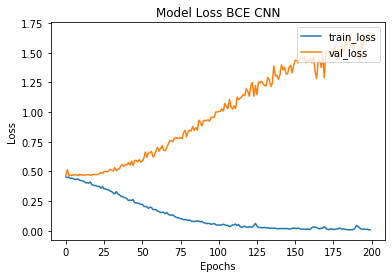

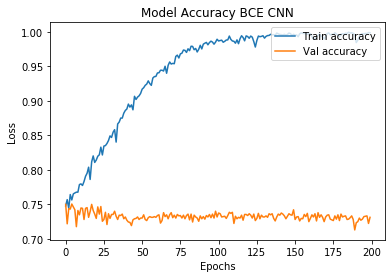

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.794521,0.790698,0.792605,0.731244,0.704908,0.73097
Confirmed,0.614476,0.619970,0.617211,0.731244,0.704908,0.73097


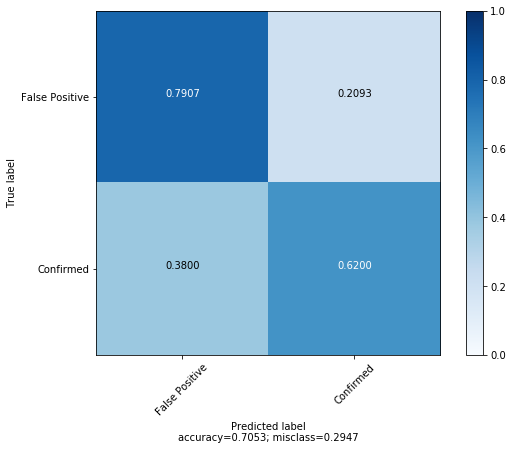

In [29]:
## matriz de 30x30
train_model(model, x_train, y_train, x_val, y_val, e=200) #sin focal

## Otro tipo de modelos (deep) - midiendo f1

In [67]:
import keras
class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []

    def on_epoch_end(self, batch, logs={}):
        predict = np.squeeze(self.model.predict_classes(self.validation_data[0]))
        targ = np.squeeze(self.validation_data[1])
        f1s = f1_score(targ, predict, average='macro')
        self.val_f1s.append(f1s)
        print(" - val_f1: %f " %(f1s))
        return


def train_model(aux_model, x_train, y_train, x_val, y_val, e=25, BS=128):
    model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
    
    metrics = Metrics()
    hist=aux_model.fit(x_train, y_train, batch_size=BS, epochs=e, verbose=1, validation_data=(x_val,y_val),
                      callbacks=[metrics])
    
    plt.figure(figsize=(12,5))
    plt.plot(hist.history['loss'],label="train_loss")
    plt.plot(hist.history['val_loss'],label="val_loss")
    plt.title("Model Loss BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    plt.figure(figsize=(12,5))
    plt.plot(hist.history['acc'],label="Train accuracy" )
    plt.plot(hist.history['val_acc'],label="Val accuracy" )
    plt.title("Model Accuracy BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()
    
    plt.figure(figsize=(12,5))
    plt.plot(hist.history['val_loss'],label="loss" )
    plt.plot(hist.history['val_acc'],label="accuracy" )
    plt.plot(metrics.val_f1s,label="F1" )
    plt.ylabel("Metric")
    plt.xlabel('Epochs')
    plt.title("Test set/val")
    #plt.legend(loc="upper right")
    plt.show()

    predichos=aux_model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')

In [71]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

#model.add(Conv2D(256, (2, 2), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
#model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 32)        608       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 128)        

Train on 4339 samples, validate on 1918 samples
Epoch 1/100
4339/4339 [==============================] - 4s 993us/step - loss: 0.5967 - acc: 0.6193 - val_loss: 0.5587 - val_acc: 0.6267
 - val_f1: 0.615020 
Epoch 2/100
4339/4339 [==============================] - 2s 435us/step - loss: 0.5700 - acc: 0.6310 - val_loss: 0.5538 - val_acc: 0.6502
 - val_f1: 0.393997 
Epoch 3/100
 384/4339 [=>............................] - ETA: 1s - loss: 0.5486 - acc: 0.6406

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


4339/4339 [==============================] - 2s 457us/step - loss: 0.5613 - acc: 0.6292 - val_loss: 0.5539 - val_acc: 0.6502
 - val_f1: 0.393997 
Epoch 4/100
4339/4339 [==============================] - 2s 436us/step - loss: 0.5609 - acc: 0.6283 - val_loss: 0.5438 - val_acc: 0.6502
 - val_f1: 0.393997 
Epoch 5/100
4339/4339 [==============================] - 2s 462us/step - loss: 0.5505 - acc: 0.6317 - val_loss: 0.5523 - val_acc: 0.6283
 - val_f1: 0.613970 
Epoch 6/100
4339/4339 [==============================] - 2s 477us/step - loss: 0.5534 - acc: 0.6230 - val_loss: 0.5381 - val_acc: 0.6502
 - val_f1: 0.393997 
Epoch 7/100
4339/4339 [==============================] - 2s 459us/step - loss: 0.5437 - acc: 0.6266 - val_loss: 0.5304 - val_acc: 0.6382
 - val_f1: 0.635997 
Epoch 8/100
4339/4339 [==============================] - 2s 487us/step - loss: 0.5391 - acc: 0.6368 - val_loss: 0.5277 - val_acc: 0.6809
 - val_f1: 0.581731 
Epoch 9/100
4339/4339 [==============================] - 2s 464u

 - val_f1: 0.700292 
Epoch 55/100
4339/4339 [==============================] - 2s 399us/step - loss: 0.4508 - acc: 0.7345 - val_loss: 0.4597 - val_acc: 0.7440
 - val_f1: 0.699375 
Epoch 56/100
4339/4339 [==============================] - 2s 418us/step - loss: 0.4469 - acc: 0.7396 - val_loss: 0.4551 - val_acc: 0.7503
 - val_f1: 0.721641 
Epoch 57/100
4339/4339 [==============================] - 2s 478us/step - loss: 0.4423 - acc: 0.7476 - val_loss: 0.4665 - val_acc: 0.7445
 - val_f1: 0.702619 
Epoch 58/100
4339/4339 [==============================] - 2s 412us/step - loss: 0.4476 - acc: 0.7361 - val_loss: 0.4607 - val_acc: 0.7388
 - val_f1: 0.713777 
Epoch 59/100
4339/4339 [==============================] - 2s 403us/step - loss: 0.4491 - acc: 0.7396 - val_loss: 0.4681 - val_acc: 0.7487
 - val_f1: 0.693157 
Epoch 60/100
4339/4339 [==============================] - 2s 462us/step - loss: 0.4501 - acc: 0.7373 - val_loss: 0.4580 - val_acc: 0.7445
 - val_f1: 0.689404 
Epoch 61/100
4339/4339 [=

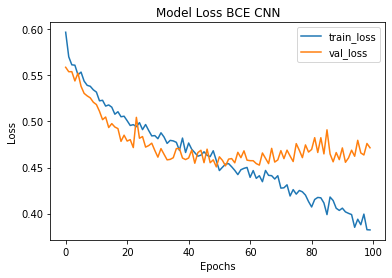

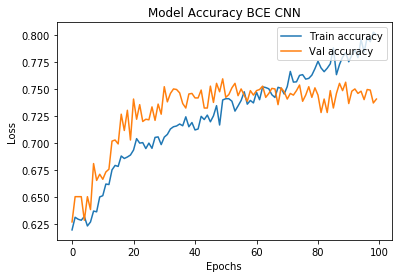

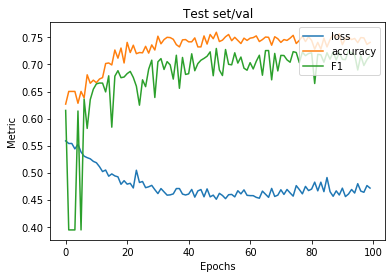

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.801932,0.798717,0.800321,0.741097,0.715677,0.740876
Confirmed,0.628698,0.633383,0.631032,0.741097,0.715677,0.740876


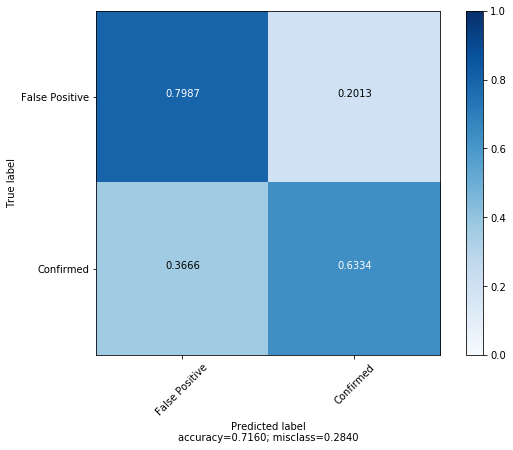

In [72]:
train_model(model, x_train, y_train, x_val, y_val, e=100, BS=128)
